In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn.functional import relu

In [7]:
print('test')

test


In [8]:
print('test')
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1=nn.Linear(1, 20)
        self.l2=nn.Linear(20, 20)
        self.l3=nn.Linear(20, 20)
        self.l4=nn.Linear(20, 20)
        self.l5=nn.Linear(20, 1)
        
    def forward(self, x):
        out=torch.tanh(self.l1(x)) #does not work wth only relu, tanh better than sigmoid
        out=torch.tanh(self.l2(out))
        out=torch.tanh(self.l3(out))
        out=torch.tanh(self.l4(out))
        out=self.l5(out)
        return out
k=1
m=1
def f(net,t):
    u=net(t)
    #v = torch.autograd.grad(u, t, create_graph=True,grad_outputs=torch.ones_like(u))[0] is the same
    v = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    a = torch.autograd.grad(v.sum(), t, create_graph=True)[0]
    
    mse1=nn.MSELoss()
    pt02 = Variable(torch.from_numpy(np.zeros((100,1))).float(), requires_grad=False).to(device)
    return mse1(k*u+m*a,pt02)

def u_err(net,t0,u0):
    u=net(t0)
    
    mse1=nn.MSELoss()
    return mse1(u,u0)

def u_err_v(net,t0,v0):
    u=net(t0)
    v0net=torch.autograd.grad(u.sum(), t0, create_graph=True)[0]
    
    mse1=nn.MSELoss()
    return mse1(v0net,v0)


test
Using cpu device


In [9]:

model = NeuralNetwork().to(device)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
optimizer=torch.optim.Adam(model.parameters())
for i in range(20000):
    optimizer.zero_grad()
    t_bc=np.array([[0.0]])
    u_bc=np.array([[0.0]])
    v_bc=np.array([[1.0]])
    pt_t_bc = Variable(torch.from_numpy(t_bc).float(), requires_grad=True).to(device)
    pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)
    pt_v_bc = Variable(torch.from_numpy(v_bc).float(), requires_grad=False).to(device)
    
    loss1=u_err(model,pt_t_bc,pt_u_bc)+u_err_v(model,pt_t_bc,pt_v_bc)

    t=np.random.rand(100,1)*10.0#*min((3+7.0/10000.0*i),10.0)
    pt_t= Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)
    
    loss2=f(model,pt_t)
    
    loss = loss1+loss2

    # Backpropagation
    loss.backward()
    optimizer.step()
    print(i)
    print(loss)

0
tensor(1.1847, grad_fn=<AddBackward0>)
1
tensor(1.1531, grad_fn=<AddBackward0>)
2
tensor(1.1241, grad_fn=<AddBackward0>)
3
tensor(1.0973, grad_fn=<AddBackward0>)
4
tensor(1.0727, grad_fn=<AddBackward0>)
5
tensor(1.0499, grad_fn=<AddBackward0>)
6
tensor(1.0286, grad_fn=<AddBackward0>)
7
tensor(1.0086, grad_fn=<AddBackward0>)
8
tensor(0.9894, grad_fn=<AddBackward0>)
9
tensor(0.9712, grad_fn=<AddBackward0>)
10
tensor(0.9532, grad_fn=<AddBackward0>)
11
tensor(0.9358, grad_fn=<AddBackward0>)
12
tensor(0.9186, grad_fn=<AddBackward0>)
13
tensor(0.9016, grad_fn=<AddBackward0>)
14
tensor(0.8846, grad_fn=<AddBackward0>)
15
tensor(0.8662, grad_fn=<AddBackward0>)
16
tensor(0.8504, grad_fn=<AddBackward0>)
17
tensor(0.8329, grad_fn=<AddBackward0>)
18
tensor(0.8154, grad_fn=<AddBackward0>)
19
tensor(0.7966, grad_fn=<AddBackward0>)
20
tensor(0.7794, grad_fn=<AddBackward0>)
21
tensor(0.7595, grad_fn=<AddBackward0>)
22
tensor(0.7393, grad_fn=<AddBackward0>)
23
tensor(0.7188, grad_fn=<AddBackward0>)
24

201
tensor(0.0428, grad_fn=<AddBackward0>)
202
tensor(0.0598, grad_fn=<AddBackward0>)
203
tensor(0.0667, grad_fn=<AddBackward0>)
204
tensor(0.0403, grad_fn=<AddBackward0>)
205
tensor(0.0549, grad_fn=<AddBackward0>)
206
tensor(0.0661, grad_fn=<AddBackward0>)
207
tensor(0.0544, grad_fn=<AddBackward0>)
208
tensor(0.0588, grad_fn=<AddBackward0>)
209
tensor(0.0547, grad_fn=<AddBackward0>)
210
tensor(0.0591, grad_fn=<AddBackward0>)
211
tensor(0.0504, grad_fn=<AddBackward0>)
212
tensor(0.0573, grad_fn=<AddBackward0>)
213
tensor(0.0423, grad_fn=<AddBackward0>)
214
tensor(0.0585, grad_fn=<AddBackward0>)
215
tensor(0.0455, grad_fn=<AddBackward0>)
216
tensor(0.0457, grad_fn=<AddBackward0>)
217
tensor(0.0538, grad_fn=<AddBackward0>)
218
tensor(0.0563, grad_fn=<AddBackward0>)
219
tensor(0.0559, grad_fn=<AddBackward0>)
220
tensor(0.0544, grad_fn=<AddBackward0>)
221
tensor(0.0513, grad_fn=<AddBackward0>)
222
tensor(0.0461, grad_fn=<AddBackward0>)
223
tensor(0.0485, grad_fn=<AddBackward0>)
224
tensor(

411
tensor(0.0387, grad_fn=<AddBackward0>)
412
tensor(0.0364, grad_fn=<AddBackward0>)
413
tensor(0.0344, grad_fn=<AddBackward0>)
414
tensor(0.0336, grad_fn=<AddBackward0>)
415
tensor(0.0385, grad_fn=<AddBackward0>)
416
tensor(0.0238, grad_fn=<AddBackward0>)
417
tensor(0.0444, grad_fn=<AddBackward0>)
418
tensor(0.0381, grad_fn=<AddBackward0>)
419
tensor(0.0340, grad_fn=<AddBackward0>)
420
tensor(0.0428, grad_fn=<AddBackward0>)
421
tensor(0.0392, grad_fn=<AddBackward0>)
422
tensor(0.0380, grad_fn=<AddBackward0>)
423
tensor(0.0370, grad_fn=<AddBackward0>)
424
tensor(0.0424, grad_fn=<AddBackward0>)
425
tensor(0.0355, grad_fn=<AddBackward0>)
426
tensor(0.0359, grad_fn=<AddBackward0>)
427
tensor(0.0356, grad_fn=<AddBackward0>)
428
tensor(0.0383, grad_fn=<AddBackward0>)
429
tensor(0.0385, grad_fn=<AddBackward0>)
430
tensor(0.0397, grad_fn=<AddBackward0>)
431
tensor(0.0450, grad_fn=<AddBackward0>)
432
tensor(0.0219, grad_fn=<AddBackward0>)
433
tensor(0.0344, grad_fn=<AddBackward0>)
434
tensor(

627
tensor(0.0411, grad_fn=<AddBackward0>)
628
tensor(0.0351, grad_fn=<AddBackward0>)
629
tensor(0.0382, grad_fn=<AddBackward0>)
630
tensor(0.0304, grad_fn=<AddBackward0>)
631
tensor(0.0314, grad_fn=<AddBackward0>)
632
tensor(0.0366, grad_fn=<AddBackward0>)
633
tensor(0.0262, grad_fn=<AddBackward0>)
634
tensor(0.0340, grad_fn=<AddBackward0>)
635
tensor(0.0312, grad_fn=<AddBackward0>)
636
tensor(0.0327, grad_fn=<AddBackward0>)
637
tensor(0.0305, grad_fn=<AddBackward0>)
638
tensor(0.0326, grad_fn=<AddBackward0>)
639
tensor(0.0266, grad_fn=<AddBackward0>)
640
tensor(0.0333, grad_fn=<AddBackward0>)
641
tensor(0.0274, grad_fn=<AddBackward0>)
642
tensor(0.0361, grad_fn=<AddBackward0>)
643
tensor(0.0359, grad_fn=<AddBackward0>)
644
tensor(0.0311, grad_fn=<AddBackward0>)
645
tensor(0.0361, grad_fn=<AddBackward0>)
646
tensor(0.0343, grad_fn=<AddBackward0>)
647
tensor(0.0291, grad_fn=<AddBackward0>)
648
tensor(0.0337, grad_fn=<AddBackward0>)
649
tensor(0.0329, grad_fn=<AddBackward0>)
650
tensor(

830
tensor(0.0336, grad_fn=<AddBackward0>)
831
tensor(0.0275, grad_fn=<AddBackward0>)
832
tensor(0.0229, grad_fn=<AddBackward0>)
833
tensor(0.0320, grad_fn=<AddBackward0>)
834
tensor(0.0284, grad_fn=<AddBackward0>)
835
tensor(0.0353, grad_fn=<AddBackward0>)
836
tensor(0.0329, grad_fn=<AddBackward0>)
837
tensor(0.0313, grad_fn=<AddBackward0>)
838
tensor(0.0319, grad_fn=<AddBackward0>)
839
tensor(0.0331, grad_fn=<AddBackward0>)
840
tensor(0.0348, grad_fn=<AddBackward0>)
841
tensor(0.0306, grad_fn=<AddBackward0>)
842
tensor(0.0295, grad_fn=<AddBackward0>)
843
tensor(0.0272, grad_fn=<AddBackward0>)
844
tensor(0.0317, grad_fn=<AddBackward0>)
845
tensor(0.0269, grad_fn=<AddBackward0>)
846
tensor(0.0347, grad_fn=<AddBackward0>)
847
tensor(0.0277, grad_fn=<AddBackward0>)
848
tensor(0.0331, grad_fn=<AddBackward0>)
849
tensor(0.0372, grad_fn=<AddBackward0>)
850
tensor(0.0312, grad_fn=<AddBackward0>)
851
tensor(0.0324, grad_fn=<AddBackward0>)
852
tensor(0.0363, grad_fn=<AddBackward0>)
853
tensor(

1027
tensor(0.0251, grad_fn=<AddBackward0>)
1028
tensor(0.0324, grad_fn=<AddBackward0>)
1029
tensor(0.0303, grad_fn=<AddBackward0>)
1030
tensor(0.0270, grad_fn=<AddBackward0>)
1031
tensor(0.0318, grad_fn=<AddBackward0>)
1032
tensor(0.0331, grad_fn=<AddBackward0>)
1033
tensor(0.0332, grad_fn=<AddBackward0>)
1034
tensor(0.0329, grad_fn=<AddBackward0>)
1035
tensor(0.0311, grad_fn=<AddBackward0>)
1036
tensor(0.0289, grad_fn=<AddBackward0>)
1037
tensor(0.0301, grad_fn=<AddBackward0>)
1038
tensor(0.0342, grad_fn=<AddBackward0>)
1039
tensor(0.0322, grad_fn=<AddBackward0>)
1040
tensor(0.0280, grad_fn=<AddBackward0>)
1041
tensor(0.0302, grad_fn=<AddBackward0>)
1042
tensor(0.0340, grad_fn=<AddBackward0>)
1043
tensor(0.0251, grad_fn=<AddBackward0>)
1044
tensor(0.0365, grad_fn=<AddBackward0>)
1045
tensor(0.0363, grad_fn=<AddBackward0>)
1046
tensor(0.0318, grad_fn=<AddBackward0>)
1047
tensor(0.0310, grad_fn=<AddBackward0>)
1048
tensor(0.0232, grad_fn=<AddBackward0>)
1049
tensor(0.0338, grad_fn=<Add

1250
tensor(0.0311, grad_fn=<AddBackward0>)
1251
tensor(0.0273, grad_fn=<AddBackward0>)
1252
tensor(0.0312, grad_fn=<AddBackward0>)
1253
tensor(0.0225, grad_fn=<AddBackward0>)
1254
tensor(0.0249, grad_fn=<AddBackward0>)
1255
tensor(0.0287, grad_fn=<AddBackward0>)
1256
tensor(0.0268, grad_fn=<AddBackward0>)
1257
tensor(0.0334, grad_fn=<AddBackward0>)
1258
tensor(0.0301, grad_fn=<AddBackward0>)
1259
tensor(0.0284, grad_fn=<AddBackward0>)
1260
tensor(0.0294, grad_fn=<AddBackward0>)
1261
tensor(0.0282, grad_fn=<AddBackward0>)
1262
tensor(0.0236, grad_fn=<AddBackward0>)
1263
tensor(0.0334, grad_fn=<AddBackward0>)
1264
tensor(0.0274, grad_fn=<AddBackward0>)
1265
tensor(0.0242, grad_fn=<AddBackward0>)
1266
tensor(0.0306, grad_fn=<AddBackward0>)
1267
tensor(0.0299, grad_fn=<AddBackward0>)
1268
tensor(0.0277, grad_fn=<AddBackward0>)
1269
tensor(0.0271, grad_fn=<AddBackward0>)
1270
tensor(0.0325, grad_fn=<AddBackward0>)
1271
tensor(0.0333, grad_fn=<AddBackward0>)
1272
tensor(0.0309, grad_fn=<Add

tensor(0.0292, grad_fn=<AddBackward0>)
1469
tensor(0.0288, grad_fn=<AddBackward0>)
1470
tensor(0.0301, grad_fn=<AddBackward0>)
1471
tensor(0.0338, grad_fn=<AddBackward0>)
1472
tensor(0.0265, grad_fn=<AddBackward0>)
1473
tensor(0.0289, grad_fn=<AddBackward0>)
1474
tensor(0.0286, grad_fn=<AddBackward0>)
1475
tensor(0.0271, grad_fn=<AddBackward0>)
1476
tensor(0.0292, grad_fn=<AddBackward0>)
1477
tensor(0.0309, grad_fn=<AddBackward0>)
1478
tensor(0.0293, grad_fn=<AddBackward0>)
1479
tensor(0.0240, grad_fn=<AddBackward0>)
1480
tensor(0.0255, grad_fn=<AddBackward0>)
1481
tensor(0.0279, grad_fn=<AddBackward0>)
1482
tensor(0.0343, grad_fn=<AddBackward0>)
1483
tensor(0.0289, grad_fn=<AddBackward0>)
1484
tensor(0.0291, grad_fn=<AddBackward0>)
1485
tensor(0.0325, grad_fn=<AddBackward0>)
1486
tensor(0.0262, grad_fn=<AddBackward0>)
1487
tensor(0.0268, grad_fn=<AddBackward0>)
1488
tensor(0.0292, grad_fn=<AddBackward0>)
1489
tensor(0.0285, grad_fn=<AddBackward0>)
1490
tensor(0.0312, grad_fn=<AddBackw

1689
tensor(0.0280, grad_fn=<AddBackward0>)
1690
tensor(0.0317, grad_fn=<AddBackward0>)
1691
tensor(0.0300, grad_fn=<AddBackward0>)
1692
tensor(0.0297, grad_fn=<AddBackward0>)
1693
tensor(0.0270, grad_fn=<AddBackward0>)
1694
tensor(0.0296, grad_fn=<AddBackward0>)
1695
tensor(0.0264, grad_fn=<AddBackward0>)
1696
tensor(0.0264, grad_fn=<AddBackward0>)
1697
tensor(0.0230, grad_fn=<AddBackward0>)
1698
tensor(0.0295, grad_fn=<AddBackward0>)
1699
tensor(0.0292, grad_fn=<AddBackward0>)
1700
tensor(0.0297, grad_fn=<AddBackward0>)
1701
tensor(0.0291, grad_fn=<AddBackward0>)
1702
tensor(0.0271, grad_fn=<AddBackward0>)
1703
tensor(0.0274, grad_fn=<AddBackward0>)
1704
tensor(0.0301, grad_fn=<AddBackward0>)
1705
tensor(0.0336, grad_fn=<AddBackward0>)
1706
tensor(0.0286, grad_fn=<AddBackward0>)
1707
tensor(0.0309, grad_fn=<AddBackward0>)
1708
tensor(0.0274, grad_fn=<AddBackward0>)
1709
tensor(0.0310, grad_fn=<AddBackward0>)
1710
tensor(0.0329, grad_fn=<AddBackward0>)
1711
tensor(0.0305, grad_fn=<Add

1888
tensor(0.0308, grad_fn=<AddBackward0>)
1889
tensor(0.0298, grad_fn=<AddBackward0>)
1890
tensor(0.0272, grad_fn=<AddBackward0>)
1891
tensor(0.0314, grad_fn=<AddBackward0>)
1892
tensor(0.0282, grad_fn=<AddBackward0>)
1893
tensor(0.0354, grad_fn=<AddBackward0>)
1894
tensor(0.0292, grad_fn=<AddBackward0>)
1895
tensor(0.0275, grad_fn=<AddBackward0>)
1896
tensor(0.0280, grad_fn=<AddBackward0>)
1897
tensor(0.0249, grad_fn=<AddBackward0>)
1898
tensor(0.0294, grad_fn=<AddBackward0>)
1899
tensor(0.0265, grad_fn=<AddBackward0>)
1900
tensor(0.0273, grad_fn=<AddBackward0>)
1901
tensor(0.0205, grad_fn=<AddBackward0>)
1902
tensor(0.0266, grad_fn=<AddBackward0>)
1903
tensor(0.0300, grad_fn=<AddBackward0>)
1904
tensor(0.0289, grad_fn=<AddBackward0>)
1905
tensor(0.0273, grad_fn=<AddBackward0>)
1906
tensor(0.0251, grad_fn=<AddBackward0>)
1907
tensor(0.0256, grad_fn=<AddBackward0>)
1908
tensor(0.0274, grad_fn=<AddBackward0>)
1909
tensor(0.0257, grad_fn=<AddBackward0>)
1910
tensor(0.0286, grad_fn=<Add

2106
tensor(0.0303, grad_fn=<AddBackward0>)
2107
tensor(0.0257, grad_fn=<AddBackward0>)
2108
tensor(0.0292, grad_fn=<AddBackward0>)
2109
tensor(0.0281, grad_fn=<AddBackward0>)
2110
tensor(0.0231, grad_fn=<AddBackward0>)
2111
tensor(0.0272, grad_fn=<AddBackward0>)
2112
tensor(0.0306, grad_fn=<AddBackward0>)
2113
tensor(0.0262, grad_fn=<AddBackward0>)
2114
tensor(0.0284, grad_fn=<AddBackward0>)
2115
tensor(0.0280, grad_fn=<AddBackward0>)
2116
tensor(0.0270, grad_fn=<AddBackward0>)
2117
tensor(0.0269, grad_fn=<AddBackward0>)
2118
tensor(0.0275, grad_fn=<AddBackward0>)
2119
tensor(0.0277, grad_fn=<AddBackward0>)
2120
tensor(0.0274, grad_fn=<AddBackward0>)
2121
tensor(0.0343, grad_fn=<AddBackward0>)
2122
tensor(0.0316, grad_fn=<AddBackward0>)
2123
tensor(0.0279, grad_fn=<AddBackward0>)
2124
tensor(0.0284, grad_fn=<AddBackward0>)
2125
tensor(0.0285, grad_fn=<AddBackward0>)
2126
tensor(0.0308, grad_fn=<AddBackward0>)
2127
tensor(0.0253, grad_fn=<AddBackward0>)
2128
tensor(0.0308, grad_fn=<Add

2333
tensor(0.0281, grad_fn=<AddBackward0>)
2334
tensor(0.0297, grad_fn=<AddBackward0>)
2335
tensor(0.0295, grad_fn=<AddBackward0>)
2336
tensor(0.0301, grad_fn=<AddBackward0>)
2337
tensor(0.0295, grad_fn=<AddBackward0>)
2338
tensor(0.0267, grad_fn=<AddBackward0>)
2339
tensor(0.0280, grad_fn=<AddBackward0>)
2340
tensor(0.0251, grad_fn=<AddBackward0>)
2341
tensor(0.0293, grad_fn=<AddBackward0>)
2342
tensor(0.0311, grad_fn=<AddBackward0>)
2343
tensor(0.0264, grad_fn=<AddBackward0>)
2344
tensor(0.0287, grad_fn=<AddBackward0>)
2345
tensor(0.0257, grad_fn=<AddBackward0>)
2346
tensor(0.0297, grad_fn=<AddBackward0>)
2347
tensor(0.0235, grad_fn=<AddBackward0>)
2348
tensor(0.0280, grad_fn=<AddBackward0>)
2349
tensor(0.0294, grad_fn=<AddBackward0>)
2350
tensor(0.0243, grad_fn=<AddBackward0>)
2351
tensor(0.0264, grad_fn=<AddBackward0>)
2352
tensor(0.0302, grad_fn=<AddBackward0>)
2353
tensor(0.0301, grad_fn=<AddBackward0>)
2354
tensor(0.0253, grad_fn=<AddBackward0>)
2355
tensor(0.0321, grad_fn=<Add

2547
tensor(0.0320, grad_fn=<AddBackward0>)
2548
tensor(0.0288, grad_fn=<AddBackward0>)
2549
tensor(0.0275, grad_fn=<AddBackward0>)
2550
tensor(0.0260, grad_fn=<AddBackward0>)
2551
tensor(0.0254, grad_fn=<AddBackward0>)
2552
tensor(0.0266, grad_fn=<AddBackward0>)
2553
tensor(0.0278, grad_fn=<AddBackward0>)
2554
tensor(0.0276, grad_fn=<AddBackward0>)
2555
tensor(0.0283, grad_fn=<AddBackward0>)
2556
tensor(0.0271, grad_fn=<AddBackward0>)
2557
tensor(0.0259, grad_fn=<AddBackward0>)
2558
tensor(0.0289, grad_fn=<AddBackward0>)
2559
tensor(0.0231, grad_fn=<AddBackward0>)
2560
tensor(0.0288, grad_fn=<AddBackward0>)
2561
tensor(0.0302, grad_fn=<AddBackward0>)
2562
tensor(0.0275, grad_fn=<AddBackward0>)
2563
tensor(0.0301, grad_fn=<AddBackward0>)
2564
tensor(0.0321, grad_fn=<AddBackward0>)
2565
tensor(0.0264, grad_fn=<AddBackward0>)
2566
tensor(0.0255, grad_fn=<AddBackward0>)
2567
tensor(0.0251, grad_fn=<AddBackward0>)
2568
tensor(0.0306, grad_fn=<AddBackward0>)
2569
tensor(0.0248, grad_fn=<Add

2762
tensor(0.0287, grad_fn=<AddBackward0>)
2763
tensor(0.0260, grad_fn=<AddBackward0>)
2764
tensor(0.0226, grad_fn=<AddBackward0>)
2765
tensor(0.0290, grad_fn=<AddBackward0>)
2766
tensor(0.0228, grad_fn=<AddBackward0>)
2767
tensor(0.0291, grad_fn=<AddBackward0>)
2768
tensor(0.0279, grad_fn=<AddBackward0>)
2769
tensor(0.0290, grad_fn=<AddBackward0>)
2770
tensor(0.0287, grad_fn=<AddBackward0>)
2771
tensor(0.0324, grad_fn=<AddBackward0>)
2772
tensor(0.0319, grad_fn=<AddBackward0>)
2773
tensor(0.0291, grad_fn=<AddBackward0>)
2774
tensor(0.0245, grad_fn=<AddBackward0>)
2775
tensor(0.0288, grad_fn=<AddBackward0>)
2776
tensor(0.0254, grad_fn=<AddBackward0>)
2777
tensor(0.0300, grad_fn=<AddBackward0>)
2778
tensor(0.0271, grad_fn=<AddBackward0>)
2779
tensor(0.0233, grad_fn=<AddBackward0>)
2780
tensor(0.0283, grad_fn=<AddBackward0>)
2781
tensor(0.0292, grad_fn=<AddBackward0>)
2782
tensor(0.0266, grad_fn=<AddBackward0>)
2783
tensor(0.0313, grad_fn=<AddBackward0>)
2784
tensor(0.0231, grad_fn=<Add

2982
tensor(0.0195, grad_fn=<AddBackward0>)
2983
tensor(0.0324, grad_fn=<AddBackward0>)
2984
tensor(0.0320, grad_fn=<AddBackward0>)
2985
tensor(0.0305, grad_fn=<AddBackward0>)
2986
tensor(0.0267, grad_fn=<AddBackward0>)
2987
tensor(0.0257, grad_fn=<AddBackward0>)
2988
tensor(0.0263, grad_fn=<AddBackward0>)
2989
tensor(0.0274, grad_fn=<AddBackward0>)
2990
tensor(0.0259, grad_fn=<AddBackward0>)
2991
tensor(0.0259, grad_fn=<AddBackward0>)
2992
tensor(0.0307, grad_fn=<AddBackward0>)
2993
tensor(0.0266, grad_fn=<AddBackward0>)
2994
tensor(0.0241, grad_fn=<AddBackward0>)
2995
tensor(0.0214, grad_fn=<AddBackward0>)
2996
tensor(0.0252, grad_fn=<AddBackward0>)
2997
tensor(0.0233, grad_fn=<AddBackward0>)
2998
tensor(0.0248, grad_fn=<AddBackward0>)
2999
tensor(0.0305, grad_fn=<AddBackward0>)
3000
tensor(0.0260, grad_fn=<AddBackward0>)
3001
tensor(0.0248, grad_fn=<AddBackward0>)
3002
tensor(0.0248, grad_fn=<AddBackward0>)
3003
tensor(0.0276, grad_fn=<AddBackward0>)
3004
tensor(0.0256, grad_fn=<Add

3182
tensor(0.0280, grad_fn=<AddBackward0>)
3183
tensor(0.0297, grad_fn=<AddBackward0>)
3184
tensor(0.0280, grad_fn=<AddBackward0>)
3185
tensor(0.0268, grad_fn=<AddBackward0>)
3186
tensor(0.0267, grad_fn=<AddBackward0>)
3187
tensor(0.0257, grad_fn=<AddBackward0>)
3188
tensor(0.0249, grad_fn=<AddBackward0>)
3189
tensor(0.0237, grad_fn=<AddBackward0>)
3190
tensor(0.0279, grad_fn=<AddBackward0>)
3191
tensor(0.0288, grad_fn=<AddBackward0>)
3192
tensor(0.0250, grad_fn=<AddBackward0>)
3193
tensor(0.0283, grad_fn=<AddBackward0>)
3194
tensor(0.0246, grad_fn=<AddBackward0>)
3195
tensor(0.0243, grad_fn=<AddBackward0>)
3196
tensor(0.0253, grad_fn=<AddBackward0>)
3197
tensor(0.0267, grad_fn=<AddBackward0>)
3198
tensor(0.0288, grad_fn=<AddBackward0>)
3199
tensor(0.0262, grad_fn=<AddBackward0>)
3200
tensor(0.0266, grad_fn=<AddBackward0>)
3201
tensor(0.0274, grad_fn=<AddBackward0>)
3202
tensor(0.0256, grad_fn=<AddBackward0>)
3203
tensor(0.0273, grad_fn=<AddBackward0>)
3204
tensor(0.0271, grad_fn=<Add

3390
tensor(0.0281, grad_fn=<AddBackward0>)
3391
tensor(0.0264, grad_fn=<AddBackward0>)
3392
tensor(0.0269, grad_fn=<AddBackward0>)
3393
tensor(0.0313, grad_fn=<AddBackward0>)
3394
tensor(0.0267, grad_fn=<AddBackward0>)
3395
tensor(0.0283, grad_fn=<AddBackward0>)
3396
tensor(0.0271, grad_fn=<AddBackward0>)
3397
tensor(0.0290, grad_fn=<AddBackward0>)
3398
tensor(0.0282, grad_fn=<AddBackward0>)
3399
tensor(0.0260, grad_fn=<AddBackward0>)
3400
tensor(0.0247, grad_fn=<AddBackward0>)
3401
tensor(0.0270, grad_fn=<AddBackward0>)
3402
tensor(0.0289, grad_fn=<AddBackward0>)
3403
tensor(0.0271, grad_fn=<AddBackward0>)
3404
tensor(0.0297, grad_fn=<AddBackward0>)
3405
tensor(0.0258, grad_fn=<AddBackward0>)
3406
tensor(0.0333, grad_fn=<AddBackward0>)
3407
tensor(0.0263, grad_fn=<AddBackward0>)
3408
tensor(0.0255, grad_fn=<AddBackward0>)
3409
tensor(0.0302, grad_fn=<AddBackward0>)
3410
tensor(0.0315, grad_fn=<AddBackward0>)
3411
tensor(0.0271, grad_fn=<AddBackward0>)
3412
tensor(0.0302, grad_fn=<Add

3589
tensor(0.0258, grad_fn=<AddBackward0>)
3590
tensor(0.0296, grad_fn=<AddBackward0>)
3591
tensor(0.0263, grad_fn=<AddBackward0>)
3592
tensor(0.0268, grad_fn=<AddBackward0>)
3593
tensor(0.0253, grad_fn=<AddBackward0>)
3594
tensor(0.0215, grad_fn=<AddBackward0>)
3595
tensor(0.0265, grad_fn=<AddBackward0>)
3596
tensor(0.0227, grad_fn=<AddBackward0>)
3597
tensor(0.0252, grad_fn=<AddBackward0>)
3598
tensor(0.0274, grad_fn=<AddBackward0>)
3599
tensor(0.0244, grad_fn=<AddBackward0>)
3600
tensor(0.0239, grad_fn=<AddBackward0>)
3601
tensor(0.0228, grad_fn=<AddBackward0>)
3602
tensor(0.0266, grad_fn=<AddBackward0>)
3603
tensor(0.0279, grad_fn=<AddBackward0>)
3604
tensor(0.0312, grad_fn=<AddBackward0>)
3605
tensor(0.0249, grad_fn=<AddBackward0>)
3606
tensor(0.0264, grad_fn=<AddBackward0>)
3607
tensor(0.0276, grad_fn=<AddBackward0>)
3608
tensor(0.0305, grad_fn=<AddBackward0>)
3609
tensor(0.0255, grad_fn=<AddBackward0>)
3610
tensor(0.0297, grad_fn=<AddBackward0>)
3611
tensor(0.0305, grad_fn=<Add

3794
tensor(0.0335, grad_fn=<AddBackward0>)
3795
tensor(0.0200, grad_fn=<AddBackward0>)
3796
tensor(0.0229, grad_fn=<AddBackward0>)
3797
tensor(0.0261, grad_fn=<AddBackward0>)
3798
tensor(0.0344, grad_fn=<AddBackward0>)
3799
tensor(0.0236, grad_fn=<AddBackward0>)
3800
tensor(0.0246, grad_fn=<AddBackward0>)
3801
tensor(0.0256, grad_fn=<AddBackward0>)
3802
tensor(0.0256, grad_fn=<AddBackward0>)
3803
tensor(0.0242, grad_fn=<AddBackward0>)
3804
tensor(0.0314, grad_fn=<AddBackward0>)
3805
tensor(0.0317, grad_fn=<AddBackward0>)
3806
tensor(0.0278, grad_fn=<AddBackward0>)
3807
tensor(0.0219, grad_fn=<AddBackward0>)
3808
tensor(0.0314, grad_fn=<AddBackward0>)
3809
tensor(0.0299, grad_fn=<AddBackward0>)
3810
tensor(0.0240, grad_fn=<AddBackward0>)
3811
tensor(0.0293, grad_fn=<AddBackward0>)
3812
tensor(0.0229, grad_fn=<AddBackward0>)
3813
tensor(0.0235, grad_fn=<AddBackward0>)
3814
tensor(0.0273, grad_fn=<AddBackward0>)
3815
tensor(0.0262, grad_fn=<AddBackward0>)
3816
tensor(0.0302, grad_fn=<Add

4009
tensor(0.0306, grad_fn=<AddBackward0>)
4010
tensor(0.0273, grad_fn=<AddBackward0>)
4011
tensor(0.0233, grad_fn=<AddBackward0>)
4012
tensor(0.0258, grad_fn=<AddBackward0>)
4013
tensor(0.0283, grad_fn=<AddBackward0>)
4014
tensor(0.0218, grad_fn=<AddBackward0>)
4015
tensor(0.0229, grad_fn=<AddBackward0>)
4016
tensor(0.0248, grad_fn=<AddBackward0>)
4017
tensor(0.0274, grad_fn=<AddBackward0>)
4018
tensor(0.0221, grad_fn=<AddBackward0>)
4019
tensor(0.0301, grad_fn=<AddBackward0>)
4020
tensor(0.0262, grad_fn=<AddBackward0>)
4021
tensor(0.0237, grad_fn=<AddBackward0>)
4022
tensor(0.0233, grad_fn=<AddBackward0>)
4023
tensor(0.0260, grad_fn=<AddBackward0>)
4024
tensor(0.0276, grad_fn=<AddBackward0>)
4025
tensor(0.0244, grad_fn=<AddBackward0>)
4026
tensor(0.0259, grad_fn=<AddBackward0>)
4027
tensor(0.0263, grad_fn=<AddBackward0>)
4028
tensor(0.0289, grad_fn=<AddBackward0>)
4029
tensor(0.0295, grad_fn=<AddBackward0>)
4030
tensor(0.0251, grad_fn=<AddBackward0>)
4031
tensor(0.0238, grad_fn=<Add

4213
tensor(0.0319, grad_fn=<AddBackward0>)
4214
tensor(0.0222, grad_fn=<AddBackward0>)
4215
tensor(0.0277, grad_fn=<AddBackward0>)
4216
tensor(0.0265, grad_fn=<AddBackward0>)
4217
tensor(0.0328, grad_fn=<AddBackward0>)
4218
tensor(0.0255, grad_fn=<AddBackward0>)
4219
tensor(0.0269, grad_fn=<AddBackward0>)
4220
tensor(0.0290, grad_fn=<AddBackward0>)
4221
tensor(0.0239, grad_fn=<AddBackward0>)
4222
tensor(0.0246, grad_fn=<AddBackward0>)
4223
tensor(0.0324, grad_fn=<AddBackward0>)
4224
tensor(0.0271, grad_fn=<AddBackward0>)
4225
tensor(0.0233, grad_fn=<AddBackward0>)
4226
tensor(0.0308, grad_fn=<AddBackward0>)
4227
tensor(0.0245, grad_fn=<AddBackward0>)
4228
tensor(0.0261, grad_fn=<AddBackward0>)
4229
tensor(0.0242, grad_fn=<AddBackward0>)
4230
tensor(0.0250, grad_fn=<AddBackward0>)
4231
tensor(0.0289, grad_fn=<AddBackward0>)
4232
tensor(0.0227, grad_fn=<AddBackward0>)
4233
tensor(0.0245, grad_fn=<AddBackward0>)
4234
tensor(0.0268, grad_fn=<AddBackward0>)
4235
tensor(0.0251, grad_fn=<Add

tensor(0.0309, grad_fn=<AddBackward0>)
4412
tensor(0.0244, grad_fn=<AddBackward0>)
4413
tensor(0.0249, grad_fn=<AddBackward0>)
4414
tensor(0.0289, grad_fn=<AddBackward0>)
4415
tensor(0.0298, grad_fn=<AddBackward0>)
4416
tensor(0.0239, grad_fn=<AddBackward0>)
4417
tensor(0.0310, grad_fn=<AddBackward0>)
4418
tensor(0.0250, grad_fn=<AddBackward0>)
4419
tensor(0.0287, grad_fn=<AddBackward0>)
4420
tensor(0.0284, grad_fn=<AddBackward0>)
4421
tensor(0.0277, grad_fn=<AddBackward0>)
4422
tensor(0.0306, grad_fn=<AddBackward0>)
4423
tensor(0.0265, grad_fn=<AddBackward0>)
4424
tensor(0.0330, grad_fn=<AddBackward0>)
4425
tensor(0.0297, grad_fn=<AddBackward0>)
4426
tensor(0.0339, grad_fn=<AddBackward0>)
4427
tensor(0.0272, grad_fn=<AddBackward0>)
4428
tensor(0.0306, grad_fn=<AddBackward0>)
4429
tensor(0.0327, grad_fn=<AddBackward0>)
4430
tensor(0.0232, grad_fn=<AddBackward0>)
4431
tensor(0.0302, grad_fn=<AddBackward0>)
4432
tensor(0.0333, grad_fn=<AddBackward0>)
4433
tensor(0.0259, grad_fn=<AddBackw

4610
tensor(0.0214, grad_fn=<AddBackward0>)
4611
tensor(0.0269, grad_fn=<AddBackward0>)
4612
tensor(0.0229, grad_fn=<AddBackward0>)
4613
tensor(0.0291, grad_fn=<AddBackward0>)
4614
tensor(0.0250, grad_fn=<AddBackward0>)
4615
tensor(0.0278, grad_fn=<AddBackward0>)
4616
tensor(0.0280, grad_fn=<AddBackward0>)
4617
tensor(0.0263, grad_fn=<AddBackward0>)
4618
tensor(0.0264, grad_fn=<AddBackward0>)
4619
tensor(0.0235, grad_fn=<AddBackward0>)
4620
tensor(0.0236, grad_fn=<AddBackward0>)
4621
tensor(0.0254, grad_fn=<AddBackward0>)
4622
tensor(0.0265, grad_fn=<AddBackward0>)
4623
tensor(0.0252, grad_fn=<AddBackward0>)
4624
tensor(0.0258, grad_fn=<AddBackward0>)
4625
tensor(0.0309, grad_fn=<AddBackward0>)
4626
tensor(0.0229, grad_fn=<AddBackward0>)
4627
tensor(0.0273, grad_fn=<AddBackward0>)
4628
tensor(0.0291, grad_fn=<AddBackward0>)
4629
tensor(0.0188, grad_fn=<AddBackward0>)
4630
tensor(0.0291, grad_fn=<AddBackward0>)
4631
tensor(0.0277, grad_fn=<AddBackward0>)
4632
tensor(0.0274, grad_fn=<Add

4823
tensor(0.0252, grad_fn=<AddBackward0>)
4824
tensor(0.0299, grad_fn=<AddBackward0>)
4825
tensor(0.0261, grad_fn=<AddBackward0>)
4826
tensor(0.0259, grad_fn=<AddBackward0>)
4827
tensor(0.0277, grad_fn=<AddBackward0>)
4828
tensor(0.0266, grad_fn=<AddBackward0>)
4829
tensor(0.0246, grad_fn=<AddBackward0>)
4830
tensor(0.0248, grad_fn=<AddBackward0>)
4831
tensor(0.0282, grad_fn=<AddBackward0>)
4832
tensor(0.0239, grad_fn=<AddBackward0>)
4833
tensor(0.0245, grad_fn=<AddBackward0>)
4834
tensor(0.0243, grad_fn=<AddBackward0>)
4835
tensor(0.0287, grad_fn=<AddBackward0>)
4836
tensor(0.0235, grad_fn=<AddBackward0>)
4837
tensor(0.0273, grad_fn=<AddBackward0>)
4838
tensor(0.0199, grad_fn=<AddBackward0>)
4839
tensor(0.0284, grad_fn=<AddBackward0>)
4840
tensor(0.0254, grad_fn=<AddBackward0>)
4841
tensor(0.0275, grad_fn=<AddBackward0>)
4842
tensor(0.0307, grad_fn=<AddBackward0>)
4843
tensor(0.0257, grad_fn=<AddBackward0>)
4844
tensor(0.0245, grad_fn=<AddBackward0>)
4845
tensor(0.0214, grad_fn=<Add

5044
tensor(0.0377, grad_fn=<AddBackward0>)
5045
tensor(0.0262, grad_fn=<AddBackward0>)
5046
tensor(0.0266, grad_fn=<AddBackward0>)
5047
tensor(0.0354, grad_fn=<AddBackward0>)
5048
tensor(0.0262, grad_fn=<AddBackward0>)
5049
tensor(0.0268, grad_fn=<AddBackward0>)
5050
tensor(0.0211, grad_fn=<AddBackward0>)
5051
tensor(0.0283, grad_fn=<AddBackward0>)
5052
tensor(0.0295, grad_fn=<AddBackward0>)
5053
tensor(0.0295, grad_fn=<AddBackward0>)
5054
tensor(0.0288, grad_fn=<AddBackward0>)
5055
tensor(0.0299, grad_fn=<AddBackward0>)
5056
tensor(0.0310, grad_fn=<AddBackward0>)
5057
tensor(0.0273, grad_fn=<AddBackward0>)
5058
tensor(0.0247, grad_fn=<AddBackward0>)
5059
tensor(0.0314, grad_fn=<AddBackward0>)
5060
tensor(0.0353, grad_fn=<AddBackward0>)
5061
tensor(0.0265, grad_fn=<AddBackward0>)
5062
tensor(0.0234, grad_fn=<AddBackward0>)
5063
tensor(0.0281, grad_fn=<AddBackward0>)
5064
tensor(0.0312, grad_fn=<AddBackward0>)
5065
tensor(0.0237, grad_fn=<AddBackward0>)
5066
tensor(0.0267, grad_fn=<Add

5264
tensor(0.0297, grad_fn=<AddBackward0>)
5265
tensor(0.0238, grad_fn=<AddBackward0>)
5266
tensor(0.0287, grad_fn=<AddBackward0>)
5267
tensor(0.0310, grad_fn=<AddBackward0>)
5268
tensor(0.0253, grad_fn=<AddBackward0>)
5269
tensor(0.0238, grad_fn=<AddBackward0>)
5270
tensor(0.0270, grad_fn=<AddBackward0>)
5271
tensor(0.0247, grad_fn=<AddBackward0>)
5272
tensor(0.0274, grad_fn=<AddBackward0>)
5273
tensor(0.0197, grad_fn=<AddBackward0>)
5274
tensor(0.0238, grad_fn=<AddBackward0>)
5275
tensor(0.0293, grad_fn=<AddBackward0>)
5276
tensor(0.0298, grad_fn=<AddBackward0>)
5277
tensor(0.0275, grad_fn=<AddBackward0>)
5278
tensor(0.0310, grad_fn=<AddBackward0>)
5279
tensor(0.0230, grad_fn=<AddBackward0>)
5280
tensor(0.0209, grad_fn=<AddBackward0>)
5281
tensor(0.0261, grad_fn=<AddBackward0>)
5282
tensor(0.0265, grad_fn=<AddBackward0>)
5283
tensor(0.0239, grad_fn=<AddBackward0>)
5284
tensor(0.0322, grad_fn=<AddBackward0>)
5285
tensor(0.0231, grad_fn=<AddBackward0>)
5286
tensor(0.0301, grad_fn=<Add

5487
tensor(0.0216, grad_fn=<AddBackward0>)
5488
tensor(0.0231, grad_fn=<AddBackward0>)
5489
tensor(0.0214, grad_fn=<AddBackward0>)
5490
tensor(0.0247, grad_fn=<AddBackward0>)
5491
tensor(0.0296, grad_fn=<AddBackward0>)
5492
tensor(0.0266, grad_fn=<AddBackward0>)
5493
tensor(0.0249, grad_fn=<AddBackward0>)
5494
tensor(0.0245, grad_fn=<AddBackward0>)
5495
tensor(0.0242, grad_fn=<AddBackward0>)
5496
tensor(0.0250, grad_fn=<AddBackward0>)
5497
tensor(0.0280, grad_fn=<AddBackward0>)
5498
tensor(0.0264, grad_fn=<AddBackward0>)
5499
tensor(0.0237, grad_fn=<AddBackward0>)
5500
tensor(0.0273, grad_fn=<AddBackward0>)
5501
tensor(0.0314, grad_fn=<AddBackward0>)
5502
tensor(0.0264, grad_fn=<AddBackward0>)
5503
tensor(0.0249, grad_fn=<AddBackward0>)
5504
tensor(0.0445, grad_fn=<AddBackward0>)
5505
tensor(0.0348, grad_fn=<AddBackward0>)
5506
tensor(0.0295, grad_fn=<AddBackward0>)
5507
tensor(0.0291, grad_fn=<AddBackward0>)
5508
tensor(0.0382, grad_fn=<AddBackward0>)
5509
tensor(0.0224, grad_fn=<Add

5713
tensor(0.0266, grad_fn=<AddBackward0>)
5714
tensor(0.0288, grad_fn=<AddBackward0>)
5715
tensor(0.0193, grad_fn=<AddBackward0>)
5716
tensor(0.0286, grad_fn=<AddBackward0>)
5717
tensor(0.0234, grad_fn=<AddBackward0>)
5718
tensor(0.0255, grad_fn=<AddBackward0>)
5719
tensor(0.0216, grad_fn=<AddBackward0>)
5720
tensor(0.0266, grad_fn=<AddBackward0>)
5721
tensor(0.0256, grad_fn=<AddBackward0>)
5722
tensor(0.0229, grad_fn=<AddBackward0>)
5723
tensor(0.0230, grad_fn=<AddBackward0>)
5724
tensor(0.0219, grad_fn=<AddBackward0>)
5725
tensor(0.0242, grad_fn=<AddBackward0>)
5726
tensor(0.0237, grad_fn=<AddBackward0>)
5727
tensor(0.0273, grad_fn=<AddBackward0>)
5728
tensor(0.0257, grad_fn=<AddBackward0>)
5729
tensor(0.0288, grad_fn=<AddBackward0>)
5730
tensor(0.0248, grad_fn=<AddBackward0>)
5731
tensor(0.0223, grad_fn=<AddBackward0>)
5732
tensor(0.0294, grad_fn=<AddBackward0>)
5733
tensor(0.0260, grad_fn=<AddBackward0>)
5734
tensor(0.0229, grad_fn=<AddBackward0>)
5735
tensor(0.0274, grad_fn=<Add

tensor(0.0227, grad_fn=<AddBackward0>)
5939
tensor(0.0285, grad_fn=<AddBackward0>)
5940
tensor(0.0232, grad_fn=<AddBackward0>)
5941
tensor(0.0258, grad_fn=<AddBackward0>)
5942
tensor(0.0268, grad_fn=<AddBackward0>)
5943
tensor(0.0270, grad_fn=<AddBackward0>)
5944
tensor(0.0249, grad_fn=<AddBackward0>)
5945
tensor(0.0220, grad_fn=<AddBackward0>)
5946
tensor(0.0291, grad_fn=<AddBackward0>)
5947
tensor(0.0235, grad_fn=<AddBackward0>)
5948
tensor(0.0234, grad_fn=<AddBackward0>)
5949
tensor(0.0214, grad_fn=<AddBackward0>)
5950
tensor(0.0259, grad_fn=<AddBackward0>)
5951
tensor(0.0204, grad_fn=<AddBackward0>)
5952
tensor(0.0262, grad_fn=<AddBackward0>)
5953
tensor(0.0268, grad_fn=<AddBackward0>)
5954
tensor(0.0251, grad_fn=<AddBackward0>)
5955
tensor(0.0278, grad_fn=<AddBackward0>)
5956
tensor(0.0207, grad_fn=<AddBackward0>)
5957
tensor(0.0236, grad_fn=<AddBackward0>)
5958
tensor(0.0251, grad_fn=<AddBackward0>)
5959
tensor(0.0299, grad_fn=<AddBackward0>)
5960
tensor(0.0228, grad_fn=<AddBackw

6153
tensor(0.0254, grad_fn=<AddBackward0>)
6154
tensor(0.0205, grad_fn=<AddBackward0>)
6155
tensor(0.0213, grad_fn=<AddBackward0>)
6156
tensor(0.0210, grad_fn=<AddBackward0>)
6157
tensor(0.0223, grad_fn=<AddBackward0>)
6158
tensor(0.0201, grad_fn=<AddBackward0>)
6159
tensor(0.0225, grad_fn=<AddBackward0>)
6160
tensor(0.0254, grad_fn=<AddBackward0>)
6161
tensor(0.0251, grad_fn=<AddBackward0>)
6162
tensor(0.0224, grad_fn=<AddBackward0>)
6163
tensor(0.0221, grad_fn=<AddBackward0>)
6164
tensor(0.0233, grad_fn=<AddBackward0>)
6165
tensor(0.0267, grad_fn=<AddBackward0>)
6166
tensor(0.0269, grad_fn=<AddBackward0>)
6167
tensor(0.0251, grad_fn=<AddBackward0>)
6168
tensor(0.0225, grad_fn=<AddBackward0>)
6169
tensor(0.0275, grad_fn=<AddBackward0>)
6170
tensor(0.0246, grad_fn=<AddBackward0>)
6171
tensor(0.0274, grad_fn=<AddBackward0>)
6172
tensor(0.0260, grad_fn=<AddBackward0>)
6173
tensor(0.0199, grad_fn=<AddBackward0>)
6174
tensor(0.0281, grad_fn=<AddBackward0>)
6175
tensor(0.0337, grad_fn=<Add

6386
tensor(0.0217, grad_fn=<AddBackward0>)
6387
tensor(0.0228, grad_fn=<AddBackward0>)
6388
tensor(0.0234, grad_fn=<AddBackward0>)
6389
tensor(0.0227, grad_fn=<AddBackward0>)
6390
tensor(0.0252, grad_fn=<AddBackward0>)
6391
tensor(0.0265, grad_fn=<AddBackward0>)
6392
tensor(0.0286, grad_fn=<AddBackward0>)
6393
tensor(0.0232, grad_fn=<AddBackward0>)
6394
tensor(0.0275, grad_fn=<AddBackward0>)
6395
tensor(0.0269, grad_fn=<AddBackward0>)
6396
tensor(0.0259, grad_fn=<AddBackward0>)
6397
tensor(0.0222, grad_fn=<AddBackward0>)
6398
tensor(0.0272, grad_fn=<AddBackward0>)
6399
tensor(0.0264, grad_fn=<AddBackward0>)
6400
tensor(0.0258, grad_fn=<AddBackward0>)
6401
tensor(0.0271, grad_fn=<AddBackward0>)
6402
tensor(0.0240, grad_fn=<AddBackward0>)
6403
tensor(0.0238, grad_fn=<AddBackward0>)
6404
tensor(0.0210, grad_fn=<AddBackward0>)
6405
tensor(0.0263, grad_fn=<AddBackward0>)
6406
tensor(0.0290, grad_fn=<AddBackward0>)
6407
tensor(0.0226, grad_fn=<AddBackward0>)
6408
tensor(0.0280, grad_fn=<Add

6598
tensor(0.0223, grad_fn=<AddBackward0>)
6599
tensor(0.0234, grad_fn=<AddBackward0>)
6600
tensor(0.0259, grad_fn=<AddBackward0>)
6601
tensor(0.0262, grad_fn=<AddBackward0>)
6602
tensor(0.0219, grad_fn=<AddBackward0>)
6603
tensor(0.0281, grad_fn=<AddBackward0>)
6604
tensor(0.0245, grad_fn=<AddBackward0>)
6605
tensor(0.0219, grad_fn=<AddBackward0>)
6606
tensor(0.0282, grad_fn=<AddBackward0>)
6607
tensor(0.0235, grad_fn=<AddBackward0>)
6608
tensor(0.0228, grad_fn=<AddBackward0>)
6609
tensor(0.0252, grad_fn=<AddBackward0>)
6610
tensor(0.0220, grad_fn=<AddBackward0>)
6611
tensor(0.0228, grad_fn=<AddBackward0>)
6612
tensor(0.0240, grad_fn=<AddBackward0>)
6613
tensor(0.0196, grad_fn=<AddBackward0>)
6614
tensor(0.0236, grad_fn=<AddBackward0>)
6615
tensor(0.0221, grad_fn=<AddBackward0>)
6616
tensor(0.0221, grad_fn=<AddBackward0>)
6617
tensor(0.0181, grad_fn=<AddBackward0>)
6618
tensor(0.0229, grad_fn=<AddBackward0>)
6619
tensor(0.0225, grad_fn=<AddBackward0>)
6620
tensor(0.0209, grad_fn=<Add

6830
tensor(0.0221, grad_fn=<AddBackward0>)
6831
tensor(0.0217, grad_fn=<AddBackward0>)
6832
tensor(0.0244, grad_fn=<AddBackward0>)
6833
tensor(0.0253, grad_fn=<AddBackward0>)
6834
tensor(0.0230, grad_fn=<AddBackward0>)
6835
tensor(0.0268, grad_fn=<AddBackward0>)
6836
tensor(0.0254, grad_fn=<AddBackward0>)
6837
tensor(0.0193, grad_fn=<AddBackward0>)
6838
tensor(0.0212, grad_fn=<AddBackward0>)
6839
tensor(0.0283, grad_fn=<AddBackward0>)
6840
tensor(0.0238, grad_fn=<AddBackward0>)
6841
tensor(0.0210, grad_fn=<AddBackward0>)
6842
tensor(0.0232, grad_fn=<AddBackward0>)
6843
tensor(0.0264, grad_fn=<AddBackward0>)
6844
tensor(0.0256, grad_fn=<AddBackward0>)
6845
tensor(0.0234, grad_fn=<AddBackward0>)
6846
tensor(0.0246, grad_fn=<AddBackward0>)
6847
tensor(0.0224, grad_fn=<AddBackward0>)
6848
tensor(0.0248, grad_fn=<AddBackward0>)
6849
tensor(0.0229, grad_fn=<AddBackward0>)
6850
tensor(0.0261, grad_fn=<AddBackward0>)
6851
tensor(0.0186, grad_fn=<AddBackward0>)
6852
tensor(0.0271, grad_fn=<Add

7069
tensor(0.0220, grad_fn=<AddBackward0>)
7070
tensor(0.0197, grad_fn=<AddBackward0>)
7071
tensor(0.0219, grad_fn=<AddBackward0>)
7072
tensor(0.0238, grad_fn=<AddBackward0>)
7073
tensor(0.0222, grad_fn=<AddBackward0>)
7074
tensor(0.0225, grad_fn=<AddBackward0>)
7075
tensor(0.0189, grad_fn=<AddBackward0>)
7076
tensor(0.0145, grad_fn=<AddBackward0>)
7077
tensor(0.0219, grad_fn=<AddBackward0>)
7078
tensor(0.0226, grad_fn=<AddBackward0>)
7079
tensor(0.0229, grad_fn=<AddBackward0>)
7080
tensor(0.0203, grad_fn=<AddBackward0>)
7081
tensor(0.0239, grad_fn=<AddBackward0>)
7082
tensor(0.0256, grad_fn=<AddBackward0>)
7083
tensor(0.0263, grad_fn=<AddBackward0>)
7084
tensor(0.0221, grad_fn=<AddBackward0>)
7085
tensor(0.0227, grad_fn=<AddBackward0>)
7086
tensor(0.0209, grad_fn=<AddBackward0>)
7087
tensor(0.0215, grad_fn=<AddBackward0>)
7088
tensor(0.0225, grad_fn=<AddBackward0>)
7089
tensor(0.0174, grad_fn=<AddBackward0>)
7090
tensor(0.0222, grad_fn=<AddBackward0>)
7091
tensor(0.0209, grad_fn=<Add

7276
tensor(0.0234, grad_fn=<AddBackward0>)
7277
tensor(0.0212, grad_fn=<AddBackward0>)
7278
tensor(0.0221, grad_fn=<AddBackward0>)
7279
tensor(0.0201, grad_fn=<AddBackward0>)
7280
tensor(0.0211, grad_fn=<AddBackward0>)
7281
tensor(0.0233, grad_fn=<AddBackward0>)
7282
tensor(0.0161, grad_fn=<AddBackward0>)
7283
tensor(0.0224, grad_fn=<AddBackward0>)
7284
tensor(0.0236, grad_fn=<AddBackward0>)
7285
tensor(0.0286, grad_fn=<AddBackward0>)
7286
tensor(0.0246, grad_fn=<AddBackward0>)
7287
tensor(0.0206, grad_fn=<AddBackward0>)
7288
tensor(0.0247, grad_fn=<AddBackward0>)
7289
tensor(0.0251, grad_fn=<AddBackward0>)
7290
tensor(0.0206, grad_fn=<AddBackward0>)
7291
tensor(0.0240, grad_fn=<AddBackward0>)
7292
tensor(0.0190, grad_fn=<AddBackward0>)
7293
tensor(0.0207, grad_fn=<AddBackward0>)
7294
tensor(0.0209, grad_fn=<AddBackward0>)
7295
tensor(0.0184, grad_fn=<AddBackward0>)
7296
tensor(0.0188, grad_fn=<AddBackward0>)
7297
tensor(0.0208, grad_fn=<AddBackward0>)
7298
tensor(0.0205, grad_fn=<Add

7470
tensor(0.0202, grad_fn=<AddBackward0>)
7471
tensor(0.0202, grad_fn=<AddBackward0>)
7472
tensor(0.0216, grad_fn=<AddBackward0>)
7473
tensor(0.0181, grad_fn=<AddBackward0>)
7474
tensor(0.0209, grad_fn=<AddBackward0>)
7475
tensor(0.0187, grad_fn=<AddBackward0>)
7476
tensor(0.0199, grad_fn=<AddBackward0>)
7477
tensor(0.0202, grad_fn=<AddBackward0>)
7478
tensor(0.0185, grad_fn=<AddBackward0>)
7479
tensor(0.0238, grad_fn=<AddBackward0>)
7480
tensor(0.0197, grad_fn=<AddBackward0>)
7481
tensor(0.0197, grad_fn=<AddBackward0>)
7482
tensor(0.0184, grad_fn=<AddBackward0>)
7483
tensor(0.0215, grad_fn=<AddBackward0>)
7484
tensor(0.0250, grad_fn=<AddBackward0>)
7485
tensor(0.0243, grad_fn=<AddBackward0>)
7486
tensor(0.0191, grad_fn=<AddBackward0>)
7487
tensor(0.0191, grad_fn=<AddBackward0>)
7488
tensor(0.0256, grad_fn=<AddBackward0>)
7489
tensor(0.0219, grad_fn=<AddBackward0>)
7490
tensor(0.0269, grad_fn=<AddBackward0>)
7491
tensor(0.0264, grad_fn=<AddBackward0>)
7492
tensor(0.0230, grad_fn=<Add

7697
tensor(0.0189, grad_fn=<AddBackward0>)
7698
tensor(0.0217, grad_fn=<AddBackward0>)
7699
tensor(0.0232, grad_fn=<AddBackward0>)
7700
tensor(0.0223, grad_fn=<AddBackward0>)
7701
tensor(0.0208, grad_fn=<AddBackward0>)
7702
tensor(0.0216, grad_fn=<AddBackward0>)
7703
tensor(0.0209, grad_fn=<AddBackward0>)
7704
tensor(0.0318, grad_fn=<AddBackward0>)
7705
tensor(0.0236, grad_fn=<AddBackward0>)
7706
tensor(0.0198, grad_fn=<AddBackward0>)
7707
tensor(0.0221, grad_fn=<AddBackward0>)
7708
tensor(0.0218, grad_fn=<AddBackward0>)
7709
tensor(0.0221, grad_fn=<AddBackward0>)
7710
tensor(0.0233, grad_fn=<AddBackward0>)
7711
tensor(0.0201, grad_fn=<AddBackward0>)
7712
tensor(0.0182, grad_fn=<AddBackward0>)
7713
tensor(0.0222, grad_fn=<AddBackward0>)
7714
tensor(0.0206, grad_fn=<AddBackward0>)
7715
tensor(0.0209, grad_fn=<AddBackward0>)
7716
tensor(0.0201, grad_fn=<AddBackward0>)
7717
tensor(0.0229, grad_fn=<AddBackward0>)
7718
tensor(0.0211, grad_fn=<AddBackward0>)
7719
tensor(0.0208, grad_fn=<Add

7918
tensor(0.0189, grad_fn=<AddBackward0>)
7919
tensor(0.0221, grad_fn=<AddBackward0>)
7920
tensor(0.0196, grad_fn=<AddBackward0>)
7921
tensor(0.0229, grad_fn=<AddBackward0>)
7922
tensor(0.0194, grad_fn=<AddBackward0>)
7923
tensor(0.0232, grad_fn=<AddBackward0>)
7924
tensor(0.0160, grad_fn=<AddBackward0>)
7925
tensor(0.0191, grad_fn=<AddBackward0>)
7926
tensor(0.0204, grad_fn=<AddBackward0>)
7927
tensor(0.0211, grad_fn=<AddBackward0>)
7928
tensor(0.0209, grad_fn=<AddBackward0>)
7929
tensor(0.0175, grad_fn=<AddBackward0>)
7930
tensor(0.0256, grad_fn=<AddBackward0>)
7931
tensor(0.0198, grad_fn=<AddBackward0>)
7932
tensor(0.0242, grad_fn=<AddBackward0>)
7933
tensor(0.0171, grad_fn=<AddBackward0>)
7934
tensor(0.0202, grad_fn=<AddBackward0>)
7935
tensor(0.0165, grad_fn=<AddBackward0>)
7936
tensor(0.0194, grad_fn=<AddBackward0>)
7937
tensor(0.0186, grad_fn=<AddBackward0>)
7938
tensor(0.0226, grad_fn=<AddBackward0>)
7939
tensor(0.0202, grad_fn=<AddBackward0>)
7940
tensor(0.0192, grad_fn=<Add

8157
tensor(0.0160, grad_fn=<AddBackward0>)
8158
tensor(0.0165, grad_fn=<AddBackward0>)
8159
tensor(0.0269, grad_fn=<AddBackward0>)
8160
tensor(0.0265, grad_fn=<AddBackward0>)
8161
tensor(0.0205, grad_fn=<AddBackward0>)
8162
tensor(0.0256, grad_fn=<AddBackward0>)
8163
tensor(0.0155, grad_fn=<AddBackward0>)
8164
tensor(0.0228, grad_fn=<AddBackward0>)
8165
tensor(0.0215, grad_fn=<AddBackward0>)
8166
tensor(0.0182, grad_fn=<AddBackward0>)
8167
tensor(0.0197, grad_fn=<AddBackward0>)
8168
tensor(0.0195, grad_fn=<AddBackward0>)
8169
tensor(0.0223, grad_fn=<AddBackward0>)
8170
tensor(0.0183, grad_fn=<AddBackward0>)
8171
tensor(0.0179, grad_fn=<AddBackward0>)
8172
tensor(0.0162, grad_fn=<AddBackward0>)
8173
tensor(0.0258, grad_fn=<AddBackward0>)
8174
tensor(0.0191, grad_fn=<AddBackward0>)
8175
tensor(0.0231, grad_fn=<AddBackward0>)
8176
tensor(0.0192, grad_fn=<AddBackward0>)
8177
tensor(0.0250, grad_fn=<AddBackward0>)
8178
tensor(0.0181, grad_fn=<AddBackward0>)
8179
tensor(0.0245, grad_fn=<Add

8370
tensor(0.0158, grad_fn=<AddBackward0>)
8371
tensor(0.0193, grad_fn=<AddBackward0>)
8372
tensor(0.0163, grad_fn=<AddBackward0>)
8373
tensor(0.0199, grad_fn=<AddBackward0>)
8374
tensor(0.0181, grad_fn=<AddBackward0>)
8375
tensor(0.0170, grad_fn=<AddBackward0>)
8376
tensor(0.0241, grad_fn=<AddBackward0>)
8377
tensor(0.0183, grad_fn=<AddBackward0>)
8378
tensor(0.0173, grad_fn=<AddBackward0>)
8379
tensor(0.0187, grad_fn=<AddBackward0>)
8380
tensor(0.0201, grad_fn=<AddBackward0>)
8381
tensor(0.0179, grad_fn=<AddBackward0>)
8382
tensor(0.0189, grad_fn=<AddBackward0>)
8383
tensor(0.0190, grad_fn=<AddBackward0>)
8384
tensor(0.0191, grad_fn=<AddBackward0>)
8385
tensor(0.0160, grad_fn=<AddBackward0>)
8386
tensor(0.0155, grad_fn=<AddBackward0>)
8387
tensor(0.0155, grad_fn=<AddBackward0>)
8388
tensor(0.0159, grad_fn=<AddBackward0>)
8389
tensor(0.0170, grad_fn=<AddBackward0>)
8390
tensor(0.0168, grad_fn=<AddBackward0>)
8391
tensor(0.0189, grad_fn=<AddBackward0>)
8392
tensor(0.0186, grad_fn=<Add

8600
tensor(0.0187, grad_fn=<AddBackward0>)
8601
tensor(0.0169, grad_fn=<AddBackward0>)
8602
tensor(0.0214, grad_fn=<AddBackward0>)
8603
tensor(0.0156, grad_fn=<AddBackward0>)
8604
tensor(0.0151, grad_fn=<AddBackward0>)
8605
tensor(0.0181, grad_fn=<AddBackward0>)
8606
tensor(0.0181, grad_fn=<AddBackward0>)
8607
tensor(0.0186, grad_fn=<AddBackward0>)
8608
tensor(0.0162, grad_fn=<AddBackward0>)
8609
tensor(0.0171, grad_fn=<AddBackward0>)
8610
tensor(0.0173, grad_fn=<AddBackward0>)
8611
tensor(0.0162, grad_fn=<AddBackward0>)
8612
tensor(0.0188, grad_fn=<AddBackward0>)
8613
tensor(0.0156, grad_fn=<AddBackward0>)
8614
tensor(0.0166, grad_fn=<AddBackward0>)
8615
tensor(0.0152, grad_fn=<AddBackward0>)
8616
tensor(0.0169, grad_fn=<AddBackward0>)
8617
tensor(0.0156, grad_fn=<AddBackward0>)
8618
tensor(0.0138, grad_fn=<AddBackward0>)
8619
tensor(0.0158, grad_fn=<AddBackward0>)
8620
tensor(0.0171, grad_fn=<AddBackward0>)
8621
tensor(0.0165, grad_fn=<AddBackward0>)
8622
tensor(0.0168, grad_fn=<Add

8821
tensor(0.0160, grad_fn=<AddBackward0>)
8822
tensor(0.0154, grad_fn=<AddBackward0>)
8823
tensor(0.0166, grad_fn=<AddBackward0>)
8824
tensor(0.0172, grad_fn=<AddBackward0>)
8825
tensor(0.0204, grad_fn=<AddBackward0>)
8826
tensor(0.0164, grad_fn=<AddBackward0>)
8827
tensor(0.0189, grad_fn=<AddBackward0>)
8828
tensor(0.0165, grad_fn=<AddBackward0>)
8829
tensor(0.0199, grad_fn=<AddBackward0>)
8830
tensor(0.0168, grad_fn=<AddBackward0>)
8831
tensor(0.0197, grad_fn=<AddBackward0>)
8832
tensor(0.0149, grad_fn=<AddBackward0>)
8833
tensor(0.0205, grad_fn=<AddBackward0>)
8834
tensor(0.0144, grad_fn=<AddBackward0>)
8835
tensor(0.0192, grad_fn=<AddBackward0>)
8836
tensor(0.0158, grad_fn=<AddBackward0>)
8837
tensor(0.0202, grad_fn=<AddBackward0>)
8838
tensor(0.0145, grad_fn=<AddBackward0>)
8839
tensor(0.0149, grad_fn=<AddBackward0>)
8840
tensor(0.0120, grad_fn=<AddBackward0>)
8841
tensor(0.0222, grad_fn=<AddBackward0>)
8842
tensor(0.0166, grad_fn=<AddBackward0>)
8843
tensor(0.0210, grad_fn=<Add

9042
tensor(0.0123, grad_fn=<AddBackward0>)
9043
tensor(0.0138, grad_fn=<AddBackward0>)
9044
tensor(0.0168, grad_fn=<AddBackward0>)
9045
tensor(0.0138, grad_fn=<AddBackward0>)
9046
tensor(0.0165, grad_fn=<AddBackward0>)
9047
tensor(0.0132, grad_fn=<AddBackward0>)
9048
tensor(0.0151, grad_fn=<AddBackward0>)
9049
tensor(0.0123, grad_fn=<AddBackward0>)
9050
tensor(0.0140, grad_fn=<AddBackward0>)
9051
tensor(0.0154, grad_fn=<AddBackward0>)
9052
tensor(0.0178, grad_fn=<AddBackward0>)
9053
tensor(0.0160, grad_fn=<AddBackward0>)
9054
tensor(0.0130, grad_fn=<AddBackward0>)
9055
tensor(0.0158, grad_fn=<AddBackward0>)
9056
tensor(0.0159, grad_fn=<AddBackward0>)
9057
tensor(0.0122, grad_fn=<AddBackward0>)
9058
tensor(0.0215, grad_fn=<AddBackward0>)
9059
tensor(0.0157, grad_fn=<AddBackward0>)
9060
tensor(0.0272, grad_fn=<AddBackward0>)
9061
tensor(0.0213, grad_fn=<AddBackward0>)
9062
tensor(0.0202, grad_fn=<AddBackward0>)
9063
tensor(0.0204, grad_fn=<AddBackward0>)
9064
tensor(0.0235, grad_fn=<Add

9243
tensor(0.0148, grad_fn=<AddBackward0>)
9244
tensor(0.0201, grad_fn=<AddBackward0>)
9245
tensor(0.0138, grad_fn=<AddBackward0>)
9246
tensor(0.0129, grad_fn=<AddBackward0>)
9247
tensor(0.0133, grad_fn=<AddBackward0>)
9248
tensor(0.0223, grad_fn=<AddBackward0>)
9249
tensor(0.0172, grad_fn=<AddBackward0>)
9250
tensor(0.0118, grad_fn=<AddBackward0>)
9251
tensor(0.0139, grad_fn=<AddBackward0>)
9252
tensor(0.0158, grad_fn=<AddBackward0>)
9253
tensor(0.0121, grad_fn=<AddBackward0>)
9254
tensor(0.0166, grad_fn=<AddBackward0>)
9255
tensor(0.0137, grad_fn=<AddBackward0>)
9256
tensor(0.0125, grad_fn=<AddBackward0>)
9257
tensor(0.0116, grad_fn=<AddBackward0>)
9258
tensor(0.0168, grad_fn=<AddBackward0>)
9259
tensor(0.0122, grad_fn=<AddBackward0>)
9260
tensor(0.0149, grad_fn=<AddBackward0>)
9261
tensor(0.0130, grad_fn=<AddBackward0>)
9262
tensor(0.0166, grad_fn=<AddBackward0>)
9263
tensor(0.0147, grad_fn=<AddBackward0>)
9264
tensor(0.0148, grad_fn=<AddBackward0>)
9265
tensor(0.0173, grad_fn=<Add

9456
tensor(0.0212, grad_fn=<AddBackward0>)
9457
tensor(0.0116, grad_fn=<AddBackward0>)
9458
tensor(0.0225, grad_fn=<AddBackward0>)
9459
tensor(0.0207, grad_fn=<AddBackward0>)
9460
tensor(0.0139, grad_fn=<AddBackward0>)
9461
tensor(0.0266, grad_fn=<AddBackward0>)
9462
tensor(0.0136, grad_fn=<AddBackward0>)
9463
tensor(0.0130, grad_fn=<AddBackward0>)
9464
tensor(0.0125, grad_fn=<AddBackward0>)
9465
tensor(0.0120, grad_fn=<AddBackward0>)
9466
tensor(0.0153, grad_fn=<AddBackward0>)
9467
tensor(0.0135, grad_fn=<AddBackward0>)
9468
tensor(0.0145, grad_fn=<AddBackward0>)
9469
tensor(0.0126, grad_fn=<AddBackward0>)
9470
tensor(0.0156, grad_fn=<AddBackward0>)
9471
tensor(0.0162, grad_fn=<AddBackward0>)
9472
tensor(0.0165, grad_fn=<AddBackward0>)
9473
tensor(0.0126, grad_fn=<AddBackward0>)
9474
tensor(0.0213, grad_fn=<AddBackward0>)
9475
tensor(0.0168, grad_fn=<AddBackward0>)
9476
tensor(0.0161, grad_fn=<AddBackward0>)
9477
tensor(0.0144, grad_fn=<AddBackward0>)
9478
tensor(0.0122, grad_fn=<Add

9694
tensor(0.0127, grad_fn=<AddBackward0>)
9695
tensor(0.0188, grad_fn=<AddBackward0>)
9696
tensor(0.0109, grad_fn=<AddBackward0>)
9697
tensor(0.0223, grad_fn=<AddBackward0>)
9698
tensor(0.0111, grad_fn=<AddBackward0>)
9699
tensor(0.0169, grad_fn=<AddBackward0>)
9700
tensor(0.0129, grad_fn=<AddBackward0>)
9701
tensor(0.0133, grad_fn=<AddBackward0>)
9702
tensor(0.0101, grad_fn=<AddBackward0>)
9703
tensor(0.0145, grad_fn=<AddBackward0>)
9704
tensor(0.0136, grad_fn=<AddBackward0>)
9705
tensor(0.0192, grad_fn=<AddBackward0>)
9706
tensor(0.0144, grad_fn=<AddBackward0>)
9707
tensor(0.0170, grad_fn=<AddBackward0>)
9708
tensor(0.0170, grad_fn=<AddBackward0>)
9709
tensor(0.0186, grad_fn=<AddBackward0>)
9710
tensor(0.0188, grad_fn=<AddBackward0>)
9711
tensor(0.0136, grad_fn=<AddBackward0>)
9712
tensor(0.0186, grad_fn=<AddBackward0>)
9713
tensor(0.0132, grad_fn=<AddBackward0>)
9714
tensor(0.0179, grad_fn=<AddBackward0>)
9715
tensor(0.0171, grad_fn=<AddBackward0>)
9716
tensor(0.0218, grad_fn=<Add

9921
tensor(0.0180, grad_fn=<AddBackward0>)
9922
tensor(0.0141, grad_fn=<AddBackward0>)
9923
tensor(0.0159, grad_fn=<AddBackward0>)
9924
tensor(0.0130, grad_fn=<AddBackward0>)
9925
tensor(0.0147, grad_fn=<AddBackward0>)
9926
tensor(0.0157, grad_fn=<AddBackward0>)
9927
tensor(0.0113, grad_fn=<AddBackward0>)
9928
tensor(0.0161, grad_fn=<AddBackward0>)
9929
tensor(0.0110, grad_fn=<AddBackward0>)
9930
tensor(0.0150, grad_fn=<AddBackward0>)
9931
tensor(0.0114, grad_fn=<AddBackward0>)
9932
tensor(0.0129, grad_fn=<AddBackward0>)
9933
tensor(0.0106, grad_fn=<AddBackward0>)
9934
tensor(0.0115, grad_fn=<AddBackward0>)
9935
tensor(0.0138, grad_fn=<AddBackward0>)
9936
tensor(0.0128, grad_fn=<AddBackward0>)
9937
tensor(0.0120, grad_fn=<AddBackward0>)
9938
tensor(0.0124, grad_fn=<AddBackward0>)
9939
tensor(0.0120, grad_fn=<AddBackward0>)
9940
tensor(0.0105, grad_fn=<AddBackward0>)
9941
tensor(0.0130, grad_fn=<AddBackward0>)
9942
tensor(0.0124, grad_fn=<AddBackward0>)
9943
tensor(0.0121, grad_fn=<Add

10130
tensor(0.0117, grad_fn=<AddBackward0>)
10131
tensor(0.0096, grad_fn=<AddBackward0>)
10132
tensor(0.0120, grad_fn=<AddBackward0>)
10133
tensor(0.0109, grad_fn=<AddBackward0>)
10134
tensor(0.0114, grad_fn=<AddBackward0>)
10135
tensor(0.0111, grad_fn=<AddBackward0>)
10136
tensor(0.0119, grad_fn=<AddBackward0>)
10137
tensor(0.0138, grad_fn=<AddBackward0>)
10138
tensor(0.0138, grad_fn=<AddBackward0>)
10139
tensor(0.0104, grad_fn=<AddBackward0>)
10140
tensor(0.0168, grad_fn=<AddBackward0>)
10141
tensor(0.0092, grad_fn=<AddBackward0>)
10142
tensor(0.0129, grad_fn=<AddBackward0>)
10143
tensor(0.0091, grad_fn=<AddBackward0>)
10144
tensor(0.0110, grad_fn=<AddBackward0>)
10145
tensor(0.0107, grad_fn=<AddBackward0>)
10146
tensor(0.0108, grad_fn=<AddBackward0>)
10147
tensor(0.0107, grad_fn=<AddBackward0>)
10148
tensor(0.0123, grad_fn=<AddBackward0>)
10149
tensor(0.0096, grad_fn=<AddBackward0>)
10150
tensor(0.0121, grad_fn=<AddBackward0>)
10151
tensor(0.0104, grad_fn=<AddBackward0>)
10152
tens

10352
tensor(0.0081, grad_fn=<AddBackward0>)
10353
tensor(0.0076, grad_fn=<AddBackward0>)
10354
tensor(0.0080, grad_fn=<AddBackward0>)
10355
tensor(0.0089, grad_fn=<AddBackward0>)
10356
tensor(0.0066, grad_fn=<AddBackward0>)
10357
tensor(0.0074, grad_fn=<AddBackward0>)
10358
tensor(0.0093, grad_fn=<AddBackward0>)
10359
tensor(0.0072, grad_fn=<AddBackward0>)
10360
tensor(0.0076, grad_fn=<AddBackward0>)
10361
tensor(0.0096, grad_fn=<AddBackward0>)
10362
tensor(0.0080, grad_fn=<AddBackward0>)
10363
tensor(0.0074, grad_fn=<AddBackward0>)
10364
tensor(0.0073, grad_fn=<AddBackward0>)
10365
tensor(0.0075, grad_fn=<AddBackward0>)
10366
tensor(0.0076, grad_fn=<AddBackward0>)
10367
tensor(0.0070, grad_fn=<AddBackward0>)
10368
tensor(0.0075, grad_fn=<AddBackward0>)
10369
tensor(0.0074, grad_fn=<AddBackward0>)
10370
tensor(0.0089, grad_fn=<AddBackward0>)
10371
tensor(0.0084, grad_fn=<AddBackward0>)
10372
tensor(0.0102, grad_fn=<AddBackward0>)
10373
tensor(0.0084, grad_fn=<AddBackward0>)
10374
tens

10583
tensor(0.0051, grad_fn=<AddBackward0>)
10584
tensor(0.0047, grad_fn=<AddBackward0>)
10585
tensor(0.0065, grad_fn=<AddBackward0>)
10586
tensor(0.0047, grad_fn=<AddBackward0>)
10587
tensor(0.0057, grad_fn=<AddBackward0>)
10588
tensor(0.0051, grad_fn=<AddBackward0>)
10589
tensor(0.0046, grad_fn=<AddBackward0>)
10590
tensor(0.0046, grad_fn=<AddBackward0>)
10591
tensor(0.0051, grad_fn=<AddBackward0>)
10592
tensor(0.0041, grad_fn=<AddBackward0>)
10593
tensor(0.0043, grad_fn=<AddBackward0>)
10594
tensor(0.0051, grad_fn=<AddBackward0>)
10595
tensor(0.0053, grad_fn=<AddBackward0>)
10596
tensor(0.0054, grad_fn=<AddBackward0>)
10597
tensor(0.0051, grad_fn=<AddBackward0>)
10598
tensor(0.0052, grad_fn=<AddBackward0>)
10599
tensor(0.0051, grad_fn=<AddBackward0>)
10600
tensor(0.0069, grad_fn=<AddBackward0>)
10601
tensor(0.0053, grad_fn=<AddBackward0>)
10602
tensor(0.0049, grad_fn=<AddBackward0>)
10603
tensor(0.0061, grad_fn=<AddBackward0>)
10604
tensor(0.0051, grad_fn=<AddBackward0>)
10605
tens

10815
tensor(0.0053, grad_fn=<AddBackward0>)
10816
tensor(0.0032, grad_fn=<AddBackward0>)
10817
tensor(0.0056, grad_fn=<AddBackward0>)
10818
tensor(0.0055, grad_fn=<AddBackward0>)
10819
tensor(0.0030, grad_fn=<AddBackward0>)
10820
tensor(0.0084, grad_fn=<AddBackward0>)
10821
tensor(0.0048, grad_fn=<AddBackward0>)
10822
tensor(0.0045, grad_fn=<AddBackward0>)
10823
tensor(0.0072, grad_fn=<AddBackward0>)
10824
tensor(0.0032, grad_fn=<AddBackward0>)
10825
tensor(0.0052, grad_fn=<AddBackward0>)
10826
tensor(0.0039, grad_fn=<AddBackward0>)
10827
tensor(0.0040, grad_fn=<AddBackward0>)
10828
tensor(0.0068, grad_fn=<AddBackward0>)
10829
tensor(0.0034, grad_fn=<AddBackward0>)
10830
tensor(0.0040, grad_fn=<AddBackward0>)
10831
tensor(0.0060, grad_fn=<AddBackward0>)
10832
tensor(0.0045, grad_fn=<AddBackward0>)
10833
tensor(0.0031, grad_fn=<AddBackward0>)
10834
tensor(0.0067, grad_fn=<AddBackward0>)
10835
tensor(0.0128, grad_fn=<AddBackward0>)
10836
tensor(0.0065, grad_fn=<AddBackward0>)
10837
tens

11046
tensor(0.0027, grad_fn=<AddBackward0>)
11047
tensor(0.0029, grad_fn=<AddBackward0>)
11048
tensor(0.0037, grad_fn=<AddBackward0>)
11049
tensor(0.0025, grad_fn=<AddBackward0>)
11050
tensor(0.0030, grad_fn=<AddBackward0>)
11051
tensor(0.0033, grad_fn=<AddBackward0>)
11052
tensor(0.0037, grad_fn=<AddBackward0>)
11053
tensor(0.0021, grad_fn=<AddBackward0>)
11054
tensor(0.0036, grad_fn=<AddBackward0>)
11055
tensor(0.0039, grad_fn=<AddBackward0>)
11056
tensor(0.0026, grad_fn=<AddBackward0>)
11057
tensor(0.0040, grad_fn=<AddBackward0>)
11058
tensor(0.0028, grad_fn=<AddBackward0>)
11059
tensor(0.0022, grad_fn=<AddBackward0>)
11060
tensor(0.0032, grad_fn=<AddBackward0>)
11061
tensor(0.0038, grad_fn=<AddBackward0>)
11062
tensor(0.0026, grad_fn=<AddBackward0>)
11063
tensor(0.0022, grad_fn=<AddBackward0>)
11064
tensor(0.0034, grad_fn=<AddBackward0>)
11065
tensor(0.0030, grad_fn=<AddBackward0>)
11066
tensor(0.0029, grad_fn=<AddBackward0>)
11067
tensor(0.0025, grad_fn=<AddBackward0>)
11068
tens

11278
tensor(0.0025, grad_fn=<AddBackward0>)
11279
tensor(0.0023, grad_fn=<AddBackward0>)
11280
tensor(0.0022, grad_fn=<AddBackward0>)
11281
tensor(0.0021, grad_fn=<AddBackward0>)
11282
tensor(0.0038, grad_fn=<AddBackward0>)
11283
tensor(0.0020, grad_fn=<AddBackward0>)
11284
tensor(0.0022, grad_fn=<AddBackward0>)
11285
tensor(0.0028, grad_fn=<AddBackward0>)
11286
tensor(0.0024, grad_fn=<AddBackward0>)
11287
tensor(0.0019, grad_fn=<AddBackward0>)
11288
tensor(0.0022, grad_fn=<AddBackward0>)
11289
tensor(0.0019, grad_fn=<AddBackward0>)
11290
tensor(0.0017, grad_fn=<AddBackward0>)
11291
tensor(0.0025, grad_fn=<AddBackward0>)
11292
tensor(0.0018, grad_fn=<AddBackward0>)
11293
tensor(0.0022, grad_fn=<AddBackward0>)
11294
tensor(0.0023, grad_fn=<AddBackward0>)
11295
tensor(0.0026, grad_fn=<AddBackward0>)
11296
tensor(0.0049, grad_fn=<AddBackward0>)
11297
tensor(0.0026, grad_fn=<AddBackward0>)
11298
tensor(0.0023, grad_fn=<AddBackward0>)
11299
tensor(0.0034, grad_fn=<AddBackward0>)
11300
tens

11503
tensor(0.0033, grad_fn=<AddBackward0>)
11504
tensor(0.0016, grad_fn=<AddBackward0>)
11505
tensor(0.0023, grad_fn=<AddBackward0>)
11506
tensor(0.0035, grad_fn=<AddBackward0>)
11507
tensor(0.0018, grad_fn=<AddBackward0>)
11508
tensor(0.0021, grad_fn=<AddBackward0>)
11509
tensor(0.0026, grad_fn=<AddBackward0>)
11510
tensor(0.0014, grad_fn=<AddBackward0>)
11511
tensor(0.0025, grad_fn=<AddBackward0>)
11512
tensor(0.0018, grad_fn=<AddBackward0>)
11513
tensor(0.0021, grad_fn=<AddBackward0>)
11514
tensor(0.0038, grad_fn=<AddBackward0>)
11515
tensor(0.0018, grad_fn=<AddBackward0>)
11516
tensor(0.0026, grad_fn=<AddBackward0>)
11517
tensor(0.0040, grad_fn=<AddBackward0>)
11518
tensor(0.0020, grad_fn=<AddBackward0>)
11519
tensor(0.0025, grad_fn=<AddBackward0>)
11520
tensor(0.0057, grad_fn=<AddBackward0>)
11521
tensor(0.0032, grad_fn=<AddBackward0>)
11522
tensor(0.0016, grad_fn=<AddBackward0>)
11523
tensor(0.0015, grad_fn=<AddBackward0>)
11524
tensor(0.0018, grad_fn=<AddBackward0>)
11525
tens

11723
tensor(0.0052, grad_fn=<AddBackward0>)
11724
tensor(0.0025, grad_fn=<AddBackward0>)
11725
tensor(0.0027, grad_fn=<AddBackward0>)
11726
tensor(0.0046, grad_fn=<AddBackward0>)
11727
tensor(0.0015, grad_fn=<AddBackward0>)
11728
tensor(0.0047, grad_fn=<AddBackward0>)
11729
tensor(0.0060, grad_fn=<AddBackward0>)
11730
tensor(0.0021, grad_fn=<AddBackward0>)
11731
tensor(0.0126, grad_fn=<AddBackward0>)
11732
tensor(0.0129, grad_fn=<AddBackward0>)
11733
tensor(0.0016, grad_fn=<AddBackward0>)
11734
tensor(0.0117, grad_fn=<AddBackward0>)
11735
tensor(0.0213, grad_fn=<AddBackward0>)
11736
tensor(0.0057, grad_fn=<AddBackward0>)
11737
tensor(0.0064, grad_fn=<AddBackward0>)
11738
tensor(0.0150, grad_fn=<AddBackward0>)
11739
tensor(0.0024, grad_fn=<AddBackward0>)
11740
tensor(0.0060, grad_fn=<AddBackward0>)
11741
tensor(0.0018, grad_fn=<AddBackward0>)
11742
tensor(0.0064, grad_fn=<AddBackward0>)
11743
tensor(0.0067, grad_fn=<AddBackward0>)
11744
tensor(0.0017, grad_fn=<AddBackward0>)
11745
tens

11942
tensor(0.0011, grad_fn=<AddBackward0>)
11943
tensor(0.0021, grad_fn=<AddBackward0>)
11944
tensor(0.0013, grad_fn=<AddBackward0>)
11945
tensor(0.0019, grad_fn=<AddBackward0>)
11946
tensor(0.0021, grad_fn=<AddBackward0>)
11947
tensor(0.0024, grad_fn=<AddBackward0>)
11948
tensor(0.0094, grad_fn=<AddBackward0>)
11949
tensor(0.0083, grad_fn=<AddBackward0>)
11950
tensor(0.0018, grad_fn=<AddBackward0>)
11951
tensor(0.0085, grad_fn=<AddBackward0>)
11952
tensor(0.0064, grad_fn=<AddBackward0>)
11953
tensor(0.0024, grad_fn=<AddBackward0>)
11954
tensor(0.0079, grad_fn=<AddBackward0>)
11955
tensor(0.0020, grad_fn=<AddBackward0>)
11956
tensor(0.0074, grad_fn=<AddBackward0>)
11957
tensor(0.0081, grad_fn=<AddBackward0>)
11958
tensor(0.0021, grad_fn=<AddBackward0>)
11959
tensor(0.0144, grad_fn=<AddBackward0>)
11960
tensor(0.0065, grad_fn=<AddBackward0>)
11961
tensor(0.0061, grad_fn=<AddBackward0>)
11962
tensor(0.0204, grad_fn=<AddBackward0>)
11963
tensor(0.0025, grad_fn=<AddBackward0>)
11964
tens

tensor(0.0015, grad_fn=<AddBackward0>)
12157
tensor(0.0017, grad_fn=<AddBackward0>)
12158
tensor(0.0014, grad_fn=<AddBackward0>)
12159
tensor(0.0024, grad_fn=<AddBackward0>)
12160
tensor(0.0023, grad_fn=<AddBackward0>)
12161
tensor(0.0016, grad_fn=<AddBackward0>)
12162
tensor(0.0019, grad_fn=<AddBackward0>)
12163
tensor(0.0012, grad_fn=<AddBackward0>)
12164
tensor(0.0016, grad_fn=<AddBackward0>)
12165
tensor(0.0009, grad_fn=<AddBackward0>)
12166
tensor(0.0019, grad_fn=<AddBackward0>)
12167
tensor(0.0019, grad_fn=<AddBackward0>)
12168
tensor(0.0017, grad_fn=<AddBackward0>)
12169
tensor(0.0030, grad_fn=<AddBackward0>)
12170
tensor(0.0014, grad_fn=<AddBackward0>)
12171
tensor(0.0017, grad_fn=<AddBackward0>)
12172
tensor(0.0017, grad_fn=<AddBackward0>)
12173
tensor(0.0019, grad_fn=<AddBackward0>)
12174
tensor(0.0020, grad_fn=<AddBackward0>)
12175
tensor(0.0012, grad_fn=<AddBackward0>)
12176
tensor(0.0010, grad_fn=<AddBackward0>)
12177
tensor(0.0010, grad_fn=<AddBackward0>)
12178
tensor(0.0

12380
tensor(0.0014, grad_fn=<AddBackward0>)
12381
tensor(0.0040, grad_fn=<AddBackward0>)
12382
tensor(0.0055, grad_fn=<AddBackward0>)
12383
tensor(0.0018, grad_fn=<AddBackward0>)
12384
tensor(0.0017, grad_fn=<AddBackward0>)
12385
tensor(0.0034, grad_fn=<AddBackward0>)
12386
tensor(0.0014, grad_fn=<AddBackward0>)
12387
tensor(0.0030, grad_fn=<AddBackward0>)
12388
tensor(0.0068, grad_fn=<AddBackward0>)
12389
tensor(0.0019, grad_fn=<AddBackward0>)
12390
tensor(0.0019, grad_fn=<AddBackward0>)
12391
tensor(0.0026, grad_fn=<AddBackward0>)
12392
tensor(0.0013, grad_fn=<AddBackward0>)
12393
tensor(0.0041, grad_fn=<AddBackward0>)
12394
tensor(0.0023, grad_fn=<AddBackward0>)
12395
tensor(0.0019, grad_fn=<AddBackward0>)
12396
tensor(0.0026, grad_fn=<AddBackward0>)
12397
tensor(0.0014, grad_fn=<AddBackward0>)
12398
tensor(0.0030, grad_fn=<AddBackward0>)
12399
tensor(0.0011, grad_fn=<AddBackward0>)
12400
tensor(0.0031, grad_fn=<AddBackward0>)
12401
tensor(0.0045, grad_fn=<AddBackward0>)
12402
tens

12563
tensor(0.0021, grad_fn=<AddBackward0>)
12564
tensor(0.0015, grad_fn=<AddBackward0>)
12565
tensor(0.0019, grad_fn=<AddBackward0>)
12566
tensor(0.0018, grad_fn=<AddBackward0>)
12567
tensor(0.0016, grad_fn=<AddBackward0>)
12568
tensor(0.0035, grad_fn=<AddBackward0>)
12569
tensor(0.0044, grad_fn=<AddBackward0>)
12570
tensor(0.0017, grad_fn=<AddBackward0>)
12571
tensor(0.0030, grad_fn=<AddBackward0>)
12572
tensor(0.0015, grad_fn=<AddBackward0>)
12573
tensor(0.0029, grad_fn=<AddBackward0>)
12574
tensor(0.0014, grad_fn=<AddBackward0>)
12575
tensor(0.0015, grad_fn=<AddBackward0>)
12576
tensor(0.0017, grad_fn=<AddBackward0>)
12577
tensor(0.0015, grad_fn=<AddBackward0>)
12578
tensor(0.0018, grad_fn=<AddBackward0>)
12579
tensor(0.0013, grad_fn=<AddBackward0>)
12580
tensor(0.0014, grad_fn=<AddBackward0>)
12581
tensor(0.0016, grad_fn=<AddBackward0>)
12582
tensor(0.0015, grad_fn=<AddBackward0>)
12583
tensor(0.0014, grad_fn=<AddBackward0>)
12584
tensor(0.0014, grad_fn=<AddBackward0>)
12585
tens

12789
tensor(0.0028, grad_fn=<AddBackward0>)
12790
tensor(0.0010, grad_fn=<AddBackward0>)
12791
tensor(0.0029, grad_fn=<AddBackward0>)
12792
tensor(0.0017, grad_fn=<AddBackward0>)
12793
tensor(0.0024, grad_fn=<AddBackward0>)
12794
tensor(0.0029, grad_fn=<AddBackward0>)
12795
tensor(0.0012, grad_fn=<AddBackward0>)
12796
tensor(0.0027, grad_fn=<AddBackward0>)
12797
tensor(0.0010, grad_fn=<AddBackward0>)
12798
tensor(0.0025, grad_fn=<AddBackward0>)
12799
tensor(0.0014, grad_fn=<AddBackward0>)
12800
tensor(0.0018, grad_fn=<AddBackward0>)
12801
tensor(0.0011, grad_fn=<AddBackward0>)
12802
tensor(0.0021, grad_fn=<AddBackward0>)
12803
tensor(0.0017, grad_fn=<AddBackward0>)
12804
tensor(0.0013, grad_fn=<AddBackward0>)
12805
tensor(0.0018, grad_fn=<AddBackward0>)
12806
tensor(0.0016, grad_fn=<AddBackward0>)
12807
tensor(0.0022, grad_fn=<AddBackward0>)
12808
tensor(0.0012, grad_fn=<AddBackward0>)
12809
tensor(0.0012, grad_fn=<AddBackward0>)
12810
tensor(0.0013, grad_fn=<AddBackward0>)
12811
tens

13001
tensor(0.0008, grad_fn=<AddBackward0>)
13002
tensor(0.0008, grad_fn=<AddBackward0>)
13003
tensor(0.0007, grad_fn=<AddBackward0>)
13004
tensor(0.0010, grad_fn=<AddBackward0>)
13005
tensor(0.0011, grad_fn=<AddBackward0>)
13006
tensor(0.0010, grad_fn=<AddBackward0>)
13007
tensor(0.0007, grad_fn=<AddBackward0>)
13008
tensor(0.0012, grad_fn=<AddBackward0>)
13009
tensor(0.0013, grad_fn=<AddBackward0>)
13010
tensor(0.0016, grad_fn=<AddBackward0>)
13011
tensor(0.0011, grad_fn=<AddBackward0>)
13012
tensor(0.0010, grad_fn=<AddBackward0>)
13013
tensor(0.0011, grad_fn=<AddBackward0>)
13014
tensor(0.0008, grad_fn=<AddBackward0>)
13015
tensor(0.0009, grad_fn=<AddBackward0>)
13016
tensor(0.0013, grad_fn=<AddBackward0>)
13017
tensor(0.0011, grad_fn=<AddBackward0>)
13018
tensor(0.0012, grad_fn=<AddBackward0>)
13019
tensor(0.0010, grad_fn=<AddBackward0>)
13020
tensor(0.0011, grad_fn=<AddBackward0>)
13021
tensor(0.0009, grad_fn=<AddBackward0>)
13022
tensor(0.0010, grad_fn=<AddBackward0>)
13023
tens

13208
tensor(0.0044, grad_fn=<AddBackward0>)
13209
tensor(0.0013, grad_fn=<AddBackward0>)
13210
tensor(0.0036, grad_fn=<AddBackward0>)
13211
tensor(0.0010, grad_fn=<AddBackward0>)
13212
tensor(0.0022, grad_fn=<AddBackward0>)
13213
tensor(0.0010, grad_fn=<AddBackward0>)
13214
tensor(0.0015, grad_fn=<AddBackward0>)
13215
tensor(0.0014, grad_fn=<AddBackward0>)
13216
tensor(0.0012, grad_fn=<AddBackward0>)
13217
tensor(0.0017, grad_fn=<AddBackward0>)
13218
tensor(0.0008, grad_fn=<AddBackward0>)
13219
tensor(0.0010, grad_fn=<AddBackward0>)
13220
tensor(0.0009, grad_fn=<AddBackward0>)
13221
tensor(0.0012, grad_fn=<AddBackward0>)
13222
tensor(0.0008, grad_fn=<AddBackward0>)
13223
tensor(0.0022, grad_fn=<AddBackward0>)
13224
tensor(0.0018, grad_fn=<AddBackward0>)
13225
tensor(0.0007, grad_fn=<AddBackward0>)
13226
tensor(0.0017, grad_fn=<AddBackward0>)
13227
tensor(0.0012, grad_fn=<AddBackward0>)
13228
tensor(0.0007, grad_fn=<AddBackward0>)
13229
tensor(0.0009, grad_fn=<AddBackward0>)
13230
tens

13424
tensor(0.0060, grad_fn=<AddBackward0>)
13425
tensor(0.0013, grad_fn=<AddBackward0>)
13426
tensor(0.0073, grad_fn=<AddBackward0>)
13427
tensor(0.0006, grad_fn=<AddBackward0>)
13428
tensor(0.0066, grad_fn=<AddBackward0>)
13429
tensor(0.0038, grad_fn=<AddBackward0>)
13430
tensor(0.0013, grad_fn=<AddBackward0>)
13431
tensor(0.0038, grad_fn=<AddBackward0>)
13432
tensor(0.0009, grad_fn=<AddBackward0>)
13433
tensor(0.0039, grad_fn=<AddBackward0>)
13434
tensor(0.0009, grad_fn=<AddBackward0>)
13435
tensor(0.0034, grad_fn=<AddBackward0>)
13436
tensor(0.0031, grad_fn=<AddBackward0>)
13437
tensor(0.0011, grad_fn=<AddBackward0>)
13438
tensor(0.0017, grad_fn=<AddBackward0>)
13439
tensor(0.0007, grad_fn=<AddBackward0>)
13440
tensor(0.0023, grad_fn=<AddBackward0>)
13441
tensor(0.0008, grad_fn=<AddBackward0>)
13442
tensor(0.0011, grad_fn=<AddBackward0>)
13443
tensor(0.0010, grad_fn=<AddBackward0>)
13444
tensor(0.0010, grad_fn=<AddBackward0>)
13445
tensor(0.0015, grad_fn=<AddBackward0>)
13446
tens

13644
tensor(0.0011, grad_fn=<AddBackward0>)
13645
tensor(0.0015, grad_fn=<AddBackward0>)
13646
tensor(0.0023, grad_fn=<AddBackward0>)
13647
tensor(0.0009, grad_fn=<AddBackward0>)
13648
tensor(0.0011, grad_fn=<AddBackward0>)
13649
tensor(0.0015, grad_fn=<AddBackward0>)
13650
tensor(0.0014, grad_fn=<AddBackward0>)
13651
tensor(0.0006, grad_fn=<AddBackward0>)
13652
tensor(0.0010, grad_fn=<AddBackward0>)
13653
tensor(0.0009, grad_fn=<AddBackward0>)
13654
tensor(0.0010, grad_fn=<AddBackward0>)
13655
tensor(0.0010, grad_fn=<AddBackward0>)
13656
tensor(0.0010, grad_fn=<AddBackward0>)
13657
tensor(0.0008, grad_fn=<AddBackward0>)
13658
tensor(0.0009, grad_fn=<AddBackward0>)
13659
tensor(0.0015, grad_fn=<AddBackward0>)
13660
tensor(0.0008, grad_fn=<AddBackward0>)
13661
tensor(0.0020, grad_fn=<AddBackward0>)
13662
tensor(0.0030, grad_fn=<AddBackward0>)
13663
tensor(0.0010, grad_fn=<AddBackward0>)
13664
tensor(0.0024, grad_fn=<AddBackward0>)
13665
tensor(0.0041, grad_fn=<AddBackward0>)
13666
tens

13842
tensor(0.0005, grad_fn=<AddBackward0>)
13843
tensor(0.0023, grad_fn=<AddBackward0>)
13844
tensor(0.0026, grad_fn=<AddBackward0>)
13845
tensor(0.0007, grad_fn=<AddBackward0>)
13846
tensor(0.0014, grad_fn=<AddBackward0>)
13847
tensor(0.0012, grad_fn=<AddBackward0>)
13848
tensor(0.0011, grad_fn=<AddBackward0>)
13849
tensor(0.0032, grad_fn=<AddBackward0>)
13850
tensor(0.0014, grad_fn=<AddBackward0>)
13851
tensor(0.0006, grad_fn=<AddBackward0>)
13852
tensor(0.0027, grad_fn=<AddBackward0>)
13853
tensor(0.0022, grad_fn=<AddBackward0>)
13854
tensor(0.0007, grad_fn=<AddBackward0>)
13855
tensor(0.0010, grad_fn=<AddBackward0>)
13856
tensor(0.0009, grad_fn=<AddBackward0>)
13857
tensor(0.0009, grad_fn=<AddBackward0>)
13858
tensor(0.0006, grad_fn=<AddBackward0>)
13859
tensor(0.0005, grad_fn=<AddBackward0>)
13860
tensor(0.0005, grad_fn=<AddBackward0>)
13861
tensor(0.0013, grad_fn=<AddBackward0>)
13862
tensor(0.0012, grad_fn=<AddBackward0>)
13863
tensor(0.0011, grad_fn=<AddBackward0>)
13864
tens

14067
tensor(0.0009, grad_fn=<AddBackward0>)
14068
tensor(0.0006, grad_fn=<AddBackward0>)
14069
tensor(0.0012, grad_fn=<AddBackward0>)
14070
tensor(0.0007, grad_fn=<AddBackward0>)
14071
tensor(0.0008, grad_fn=<AddBackward0>)
14072
tensor(0.0016, grad_fn=<AddBackward0>)
14073
tensor(0.0026, grad_fn=<AddBackward0>)
14074
tensor(0.0014, grad_fn=<AddBackward0>)
14075
tensor(0.0009, grad_fn=<AddBackward0>)
14076
tensor(0.0027, grad_fn=<AddBackward0>)
14077
tensor(0.0014, grad_fn=<AddBackward0>)
14078
tensor(0.0006, grad_fn=<AddBackward0>)
14079
tensor(0.0009, grad_fn=<AddBackward0>)
14080
tensor(0.0008, grad_fn=<AddBackward0>)
14081
tensor(0.0007, grad_fn=<AddBackward0>)
14082
tensor(0.0012, grad_fn=<AddBackward0>)
14083
tensor(0.0006, grad_fn=<AddBackward0>)
14084
tensor(0.0011, grad_fn=<AddBackward0>)
14085
tensor(0.0009, grad_fn=<AddBackward0>)
14086
tensor(0.0004, grad_fn=<AddBackward0>)
14087
tensor(0.0007, grad_fn=<AddBackward0>)
14088
tensor(0.0005, grad_fn=<AddBackward0>)
14089
tens

14298
tensor(0.0008, grad_fn=<AddBackward0>)
14299
tensor(0.0011, grad_fn=<AddBackward0>)
14300
tensor(0.0019, grad_fn=<AddBackward0>)
14301
tensor(0.0012, grad_fn=<AddBackward0>)
14302
tensor(0.0006, grad_fn=<AddBackward0>)
14303
tensor(0.0007, grad_fn=<AddBackward0>)
14304
tensor(0.0007, grad_fn=<AddBackward0>)
14305
tensor(0.0007, grad_fn=<AddBackward0>)
14306
tensor(0.0006, grad_fn=<AddBackward0>)
14307
tensor(0.0006, grad_fn=<AddBackward0>)
14308
tensor(0.0008, grad_fn=<AddBackward0>)
14309
tensor(0.0005, grad_fn=<AddBackward0>)
14310
tensor(0.0009, grad_fn=<AddBackward0>)
14311
tensor(0.0007, grad_fn=<AddBackward0>)
14312
tensor(0.0007, grad_fn=<AddBackward0>)
14313
tensor(0.0007, grad_fn=<AddBackward0>)
14314
tensor(0.0005, grad_fn=<AddBackward0>)
14315
tensor(0.0009, grad_fn=<AddBackward0>)
14316
tensor(0.0006, grad_fn=<AddBackward0>)
14317
tensor(0.0008, grad_fn=<AddBackward0>)
14318
tensor(0.0012, grad_fn=<AddBackward0>)
14319
tensor(0.0005, grad_fn=<AddBackward0>)
14320
tens

14518
tensor(0.0013, grad_fn=<AddBackward0>)
14519
tensor(0.0022, grad_fn=<AddBackward0>)
14520
tensor(0.0012, grad_fn=<AddBackward0>)
14521
tensor(0.0006, grad_fn=<AddBackward0>)
14522
tensor(0.0016, grad_fn=<AddBackward0>)
14523
tensor(0.0004, grad_fn=<AddBackward0>)
14524
tensor(0.0014, grad_fn=<AddBackward0>)
14525
tensor(0.0005, grad_fn=<AddBackward0>)
14526
tensor(0.0012, grad_fn=<AddBackward0>)
14527
tensor(0.0021, grad_fn=<AddBackward0>)
14528
tensor(0.0007, grad_fn=<AddBackward0>)
14529
tensor(0.0011, grad_fn=<AddBackward0>)
14530
tensor(0.0023, grad_fn=<AddBackward0>)
14531
tensor(0.0009, grad_fn=<AddBackward0>)
14532
tensor(0.0007, grad_fn=<AddBackward0>)
14533
tensor(0.0007, grad_fn=<AddBackward0>)
14534
tensor(0.0005, grad_fn=<AddBackward0>)
14535
tensor(0.0009, grad_fn=<AddBackward0>)
14536
tensor(0.0009, grad_fn=<AddBackward0>)
14537
tensor(0.0005, grad_fn=<AddBackward0>)
14538
tensor(0.0009, grad_fn=<AddBackward0>)
14539
tensor(0.0007, grad_fn=<AddBackward0>)
14540
tens

14747
tensor(0.0009, grad_fn=<AddBackward0>)
14748
tensor(0.0009, grad_fn=<AddBackward0>)
14749
tensor(0.0026, grad_fn=<AddBackward0>)
14750
tensor(0.0007, grad_fn=<AddBackward0>)
14751
tensor(0.0006, grad_fn=<AddBackward0>)
14752
tensor(0.0009, grad_fn=<AddBackward0>)
14753
tensor(0.0002, grad_fn=<AddBackward0>)
14754
tensor(0.0004, grad_fn=<AddBackward0>)
14755
tensor(0.0004, grad_fn=<AddBackward0>)
14756
tensor(0.0004, grad_fn=<AddBackward0>)
14757
tensor(0.0005, grad_fn=<AddBackward0>)
14758
tensor(0.0004, grad_fn=<AddBackward0>)
14759
tensor(0.0004, grad_fn=<AddBackward0>)
14760
tensor(0.0002, grad_fn=<AddBackward0>)
14761
tensor(0.0003, grad_fn=<AddBackward0>)
14762
tensor(0.0003, grad_fn=<AddBackward0>)
14763
tensor(0.0003, grad_fn=<AddBackward0>)
14764
tensor(0.0004, grad_fn=<AddBackward0>)
14765
tensor(0.0005, grad_fn=<AddBackward0>)
14766
tensor(0.0005, grad_fn=<AddBackward0>)
14767
tensor(0.0004, grad_fn=<AddBackward0>)
14768
tensor(0.0004, grad_fn=<AddBackward0>)
14769
tens

14955
tensor(0.0003, grad_fn=<AddBackward0>)
14956
tensor(0.0003, grad_fn=<AddBackward0>)
14957
tensor(0.0004, grad_fn=<AddBackward0>)
14958
tensor(0.0004, grad_fn=<AddBackward0>)
14959
tensor(0.0004, grad_fn=<AddBackward0>)
14960
tensor(0.0003, grad_fn=<AddBackward0>)
14961
tensor(0.0004, grad_fn=<AddBackward0>)
14962
tensor(0.0006, grad_fn=<AddBackward0>)
14963
tensor(0.0003, grad_fn=<AddBackward0>)
14964
tensor(0.0003, grad_fn=<AddBackward0>)
14965
tensor(0.0005, grad_fn=<AddBackward0>)
14966
tensor(0.0004, grad_fn=<AddBackward0>)
14967
tensor(0.0004, grad_fn=<AddBackward0>)
14968
tensor(0.0005, grad_fn=<AddBackward0>)
14969
tensor(0.0004, grad_fn=<AddBackward0>)
14970
tensor(0.0004, grad_fn=<AddBackward0>)
14971
tensor(0.0004, grad_fn=<AddBackward0>)
14972
tensor(0.0003, grad_fn=<AddBackward0>)
14973
tensor(0.0003, grad_fn=<AddBackward0>)
14974
tensor(0.0004, grad_fn=<AddBackward0>)
14975
tensor(0.0002, grad_fn=<AddBackward0>)
14976
tensor(0.0004, grad_fn=<AddBackward0>)
14977
tens

15181
tensor(0.0038, grad_fn=<AddBackward0>)
15182
tensor(0.0014, grad_fn=<AddBackward0>)
15183
tensor(0.0015, grad_fn=<AddBackward0>)
15184
tensor(0.0060, grad_fn=<AddBackward0>)
15185
tensor(0.0024, grad_fn=<AddBackward0>)
15186
tensor(0.0016, grad_fn=<AddBackward0>)
15187
tensor(0.0060, grad_fn=<AddBackward0>)
15188
tensor(0.0054, grad_fn=<AddBackward0>)
15189
tensor(0.0016, grad_fn=<AddBackward0>)
15190
tensor(0.0006, grad_fn=<AddBackward0>)
15191
tensor(0.0023, grad_fn=<AddBackward0>)
15192
tensor(0.0016, grad_fn=<AddBackward0>)
15193
tensor(0.0012, grad_fn=<AddBackward0>)
15194
tensor(0.0050, grad_fn=<AddBackward0>)
15195
tensor(0.0034, grad_fn=<AddBackward0>)
15196
tensor(0.0012, grad_fn=<AddBackward0>)
15197
tensor(0.0064, grad_fn=<AddBackward0>)
15198
tensor(0.0043, grad_fn=<AddBackward0>)
15199
tensor(0.0004, grad_fn=<AddBackward0>)
15200
tensor(0.0038, grad_fn=<AddBackward0>)
15201
tensor(0.0012, grad_fn=<AddBackward0>)
15202
tensor(0.0016, grad_fn=<AddBackward0>)
15203
tens

15400
tensor(0.0002, grad_fn=<AddBackward0>)
15401
tensor(0.0002, grad_fn=<AddBackward0>)
15402
tensor(0.0003, grad_fn=<AddBackward0>)
15403
tensor(0.0002, grad_fn=<AddBackward0>)
15404
tensor(0.0002, grad_fn=<AddBackward0>)
15405
tensor(0.0003, grad_fn=<AddBackward0>)
15406
tensor(0.0004, grad_fn=<AddBackward0>)
15407
tensor(0.0003, grad_fn=<AddBackward0>)
15408
tensor(0.0002, grad_fn=<AddBackward0>)
15409
tensor(0.0002, grad_fn=<AddBackward0>)
15410
tensor(0.0003, grad_fn=<AddBackward0>)
15411
tensor(0.0003, grad_fn=<AddBackward0>)
15412
tensor(0.0003, grad_fn=<AddBackward0>)
15413
tensor(0.0005, grad_fn=<AddBackward0>)
15414
tensor(0.0002, grad_fn=<AddBackward0>)
15415
tensor(0.0002, grad_fn=<AddBackward0>)
15416
tensor(0.0002, grad_fn=<AddBackward0>)
15417
tensor(0.0003, grad_fn=<AddBackward0>)
15418
tensor(0.0003, grad_fn=<AddBackward0>)
15419
tensor(0.0005, grad_fn=<AddBackward0>)
15420
tensor(0.0005, grad_fn=<AddBackward0>)
15421
tensor(0.0004, grad_fn=<AddBackward0>)
15422
tens

15625
tensor(0.0015, grad_fn=<AddBackward0>)
15626
tensor(0.0005, grad_fn=<AddBackward0>)
15627
tensor(0.0005, grad_fn=<AddBackward0>)
15628
tensor(0.0017, grad_fn=<AddBackward0>)
15629
tensor(0.0044, grad_fn=<AddBackward0>)
15630
tensor(0.0036, grad_fn=<AddBackward0>)
15631
tensor(0.0027, grad_fn=<AddBackward0>)
15632
tensor(0.0014, grad_fn=<AddBackward0>)
15633
tensor(0.0001, grad_fn=<AddBackward0>)
15634
tensor(0.0007, grad_fn=<AddBackward0>)
15635
tensor(0.0017, grad_fn=<AddBackward0>)
15636
tensor(0.0006, grad_fn=<AddBackward0>)
15637
tensor(0.0006, grad_fn=<AddBackward0>)
15638
tensor(0.0017, grad_fn=<AddBackward0>)
15639
tensor(0.0017, grad_fn=<AddBackward0>)
15640
tensor(0.0005, grad_fn=<AddBackward0>)
15641
tensor(0.0009, grad_fn=<AddBackward0>)
15642
tensor(0.0015, grad_fn=<AddBackward0>)
15643
tensor(0.0005, grad_fn=<AddBackward0>)
15644
tensor(0.0002, grad_fn=<AddBackward0>)
15645
tensor(0.0006, grad_fn=<AddBackward0>)
15646
tensor(0.0004, grad_fn=<AddBackward0>)
15647
tens

15831
tensor(0.0001, grad_fn=<AddBackward0>)
15832
tensor(0.0001, grad_fn=<AddBackward0>)
15833
tensor(0.0002, grad_fn=<AddBackward0>)
15834
tensor(0.0002, grad_fn=<AddBackward0>)
15835
tensor(0.0002, grad_fn=<AddBackward0>)
15836
tensor(0.0002, grad_fn=<AddBackward0>)
15837
tensor(0.0002, grad_fn=<AddBackward0>)
15838
tensor(0.0001, grad_fn=<AddBackward0>)
15839
tensor(8.9255e-05, grad_fn=<AddBackward0>)
15840
tensor(0.0001, grad_fn=<AddBackward0>)
15841
tensor(0.0002, grad_fn=<AddBackward0>)
15842
tensor(0.0002, grad_fn=<AddBackward0>)
15843
tensor(8.9569e-05, grad_fn=<AddBackward0>)
15844
tensor(0.0002, grad_fn=<AddBackward0>)
15845
tensor(0.0003, grad_fn=<AddBackward0>)
15846
tensor(0.0003, grad_fn=<AddBackward0>)
15847
tensor(0.0003, grad_fn=<AddBackward0>)
15848
tensor(0.0003, grad_fn=<AddBackward0>)
15849
tensor(0.0003, grad_fn=<AddBackward0>)
15850
tensor(0.0002, grad_fn=<AddBackward0>)
15851
tensor(0.0001, grad_fn=<AddBackward0>)
15852
tensor(0.0002, grad_fn=<AddBackward0>)
15

16034
tensor(0.0004, grad_fn=<AddBackward0>)
16035
tensor(0.0006, grad_fn=<AddBackward0>)
16036
tensor(0.0001, grad_fn=<AddBackward0>)
16037
tensor(0.0012, grad_fn=<AddBackward0>)
16038
tensor(0.0016, grad_fn=<AddBackward0>)
16039
tensor(0.0002, grad_fn=<AddBackward0>)
16040
tensor(0.0010, grad_fn=<AddBackward0>)
16041
tensor(0.0025, grad_fn=<AddBackward0>)
16042
tensor(0.0028, grad_fn=<AddBackward0>)
16043
tensor(0.0009, grad_fn=<AddBackward0>)
16044
tensor(0.0002, grad_fn=<AddBackward0>)
16045
tensor(0.0021, grad_fn=<AddBackward0>)
16046
tensor(0.0024, grad_fn=<AddBackward0>)
16047
tensor(0.0008, grad_fn=<AddBackward0>)
16048
tensor(0.0004, grad_fn=<AddBackward0>)
16049
tensor(0.0025, grad_fn=<AddBackward0>)
16050
tensor(0.0016, grad_fn=<AddBackward0>)
16051
tensor(0.0002, grad_fn=<AddBackward0>)
16052
tensor(0.0015, grad_fn=<AddBackward0>)
16053
tensor(0.0036, grad_fn=<AddBackward0>)
16054
tensor(0.0038, grad_fn=<AddBackward0>)
16055
tensor(0.0017, grad_fn=<AddBackward0>)
16056
tens

16253
tensor(7.0690e-05, grad_fn=<AddBackward0>)
16254
tensor(0.0002, grad_fn=<AddBackward0>)
16255
tensor(0.0001, grad_fn=<AddBackward0>)
16256
tensor(0.0002, grad_fn=<AddBackward0>)
16257
tensor(8.8272e-05, grad_fn=<AddBackward0>)
16258
tensor(0.0001, grad_fn=<AddBackward0>)
16259
tensor(0.0002, grad_fn=<AddBackward0>)
16260
tensor(0.0003, grad_fn=<AddBackward0>)
16261
tensor(0.0002, grad_fn=<AddBackward0>)
16262
tensor(8.4848e-05, grad_fn=<AddBackward0>)
16263
tensor(0.0001, grad_fn=<AddBackward0>)
16264
tensor(6.9310e-05, grad_fn=<AddBackward0>)
16265
tensor(0.0003, grad_fn=<AddBackward0>)
16266
tensor(0.0005, grad_fn=<AddBackward0>)
16267
tensor(0.0003, grad_fn=<AddBackward0>)
16268
tensor(8.4260e-05, grad_fn=<AddBackward0>)
16269
tensor(0.0003, grad_fn=<AddBackward0>)
16270
tensor(0.0001, grad_fn=<AddBackward0>)
16271
tensor(0.0002, grad_fn=<AddBackward0>)
16272
tensor(0.0008, grad_fn=<AddBackward0>)
16273
tensor(0.0006, grad_fn=<AddBackward0>)
16274
tensor(7.9704e-05, grad_fn=<A

16470
tensor(0.0002, grad_fn=<AddBackward0>)
16471
tensor(0.0002, grad_fn=<AddBackward0>)
16472
tensor(0.0001, grad_fn=<AddBackward0>)
16473
tensor(5.0230e-05, grad_fn=<AddBackward0>)
16474
tensor(8.4622e-05, grad_fn=<AddBackward0>)
16475
tensor(9.1493e-05, grad_fn=<AddBackward0>)
16476
tensor(9.1524e-05, grad_fn=<AddBackward0>)
16477
tensor(9.6342e-05, grad_fn=<AddBackward0>)
16478
tensor(0.0001, grad_fn=<AddBackward0>)
16479
tensor(0.0002, grad_fn=<AddBackward0>)
16480
tensor(6.3330e-05, grad_fn=<AddBackward0>)
16481
tensor(0.0003, grad_fn=<AddBackward0>)
16482
tensor(0.0004, grad_fn=<AddBackward0>)
16483
tensor(0.0001, grad_fn=<AddBackward0>)
16484
tensor(0.0002, grad_fn=<AddBackward0>)
16485
tensor(0.0001, grad_fn=<AddBackward0>)
16486
tensor(9.9222e-05, grad_fn=<AddBackward0>)
16487
tensor(0.0001, grad_fn=<AddBackward0>)
16488
tensor(6.2042e-05, grad_fn=<AddBackward0>)
16489
tensor(6.7740e-05, grad_fn=<AddBackward0>)
16490
tensor(0.0002, grad_fn=<AddBackward0>)
16491
tensor(0.0002

16683
tensor(0.0002, grad_fn=<AddBackward0>)
16684
tensor(6.9306e-05, grad_fn=<AddBackward0>)
16685
tensor(0.0001, grad_fn=<AddBackward0>)
16686
tensor(0.0001, grad_fn=<AddBackward0>)
16687
tensor(0.0002, grad_fn=<AddBackward0>)
16688
tensor(0.0002, grad_fn=<AddBackward0>)
16689
tensor(9.6499e-05, grad_fn=<AddBackward0>)
16690
tensor(0.0002, grad_fn=<AddBackward0>)
16691
tensor(0.0001, grad_fn=<AddBackward0>)
16692
tensor(7.1287e-05, grad_fn=<AddBackward0>)
16693
tensor(0.0002, grad_fn=<AddBackward0>)
16694
tensor(0.0001, grad_fn=<AddBackward0>)
16695
tensor(7.8871e-05, grad_fn=<AddBackward0>)
16696
tensor(0.0002, grad_fn=<AddBackward0>)
16697
tensor(0.0004, grad_fn=<AddBackward0>)
16698
tensor(0.0002, grad_fn=<AddBackward0>)
16699
tensor(0.0001, grad_fn=<AddBackward0>)
16700
tensor(0.0007, grad_fn=<AddBackward0>)
16701
tensor(0.0011, grad_fn=<AddBackward0>)
16702
tensor(0.0007, grad_fn=<AddBackward0>)
16703
tensor(7.6946e-05, grad_fn=<AddBackward0>)
16704
tensor(0.0004, grad_fn=<AddBa

16909
tensor(0.0004, grad_fn=<AddBackward0>)
16910
tensor(0.0003, grad_fn=<AddBackward0>)
16911
tensor(0.0002, grad_fn=<AddBackward0>)
16912
tensor(9.1498e-05, grad_fn=<AddBackward0>)
16913
tensor(4.0637e-05, grad_fn=<AddBackward0>)
16914
tensor(0.0001, grad_fn=<AddBackward0>)
16915
tensor(7.6724e-05, grad_fn=<AddBackward0>)
16916
tensor(0.0001, grad_fn=<AddBackward0>)
16917
tensor(0.0002, grad_fn=<AddBackward0>)
16918
tensor(0.0001, grad_fn=<AddBackward0>)
16919
tensor(2.2581e-05, grad_fn=<AddBackward0>)
16920
tensor(9.8743e-05, grad_fn=<AddBackward0>)
16921
tensor(0.0002, grad_fn=<AddBackward0>)
16922
tensor(7.4776e-05, grad_fn=<AddBackward0>)
16923
tensor(6.6033e-05, grad_fn=<AddBackward0>)
16924
tensor(0.0002, grad_fn=<AddBackward0>)
16925
tensor(0.0002, grad_fn=<AddBackward0>)
16926
tensor(0.0001, grad_fn=<AddBackward0>)
16927
tensor(0.0002, grad_fn=<AddBackward0>)
16928
tensor(0.0002, grad_fn=<AddBackward0>)
16929
tensor(2.4136e-05, grad_fn=<AddBackward0>)
16930
tensor(0.0002, gr

17105
tensor(0.0002, grad_fn=<AddBackward0>)
17106
tensor(0.0001, grad_fn=<AddBackward0>)
17107
tensor(0.0002, grad_fn=<AddBackward0>)
17108
tensor(0.0003, grad_fn=<AddBackward0>)
17109
tensor(0.0002, grad_fn=<AddBackward0>)
17110
tensor(0.0001, grad_fn=<AddBackward0>)
17111
tensor(0.0001, grad_fn=<AddBackward0>)
17112
tensor(0.0002, grad_fn=<AddBackward0>)
17113
tensor(6.6237e-05, grad_fn=<AddBackward0>)
17114
tensor(0.0002, grad_fn=<AddBackward0>)
17115
tensor(0.0001, grad_fn=<AddBackward0>)
17116
tensor(0.0001, grad_fn=<AddBackward0>)
17117
tensor(4.5347e-05, grad_fn=<AddBackward0>)
17118
tensor(0.0001, grad_fn=<AddBackward0>)
17119
tensor(7.7234e-05, grad_fn=<AddBackward0>)
17120
tensor(0.0001, grad_fn=<AddBackward0>)
17121
tensor(8.7156e-05, grad_fn=<AddBackward0>)
17122
tensor(0.0001, grad_fn=<AddBackward0>)
17123
tensor(9.7017e-05, grad_fn=<AddBackward0>)
17124
tensor(9.0045e-05, grad_fn=<AddBackward0>)
17125
tensor(5.9819e-05, grad_fn=<AddBackward0>)
17126
tensor(6.4954e-05, gr

17317
tensor(0.0007, grad_fn=<AddBackward0>)
17318
tensor(0.0001, grad_fn=<AddBackward0>)
17319
tensor(0.0006, grad_fn=<AddBackward0>)
17320
tensor(0.0004, grad_fn=<AddBackward0>)
17321
tensor(0.0003, grad_fn=<AddBackward0>)
17322
tensor(0.0014, grad_fn=<AddBackward0>)
17323
tensor(0.0005, grad_fn=<AddBackward0>)
17324
tensor(0.0003, grad_fn=<AddBackward0>)
17325
tensor(0.0009, grad_fn=<AddBackward0>)
17326
tensor(0.0004, grad_fn=<AddBackward0>)
17327
tensor(0.0001, grad_fn=<AddBackward0>)
17328
tensor(0.0004, grad_fn=<AddBackward0>)
17329
tensor(0.0002, grad_fn=<AddBackward0>)
17330
tensor(0.0003, grad_fn=<AddBackward0>)
17331
tensor(0.0004, grad_fn=<AddBackward0>)
17332
tensor(5.9724e-05, grad_fn=<AddBackward0>)
17333
tensor(0.0004, grad_fn=<AddBackward0>)
17334
tensor(0.0002, grad_fn=<AddBackward0>)
17335
tensor(0.0001, grad_fn=<AddBackward0>)
17336
tensor(0.0004, grad_fn=<AddBackward0>)
17337
tensor(0.0001, grad_fn=<AddBackward0>)
17338
tensor(0.0001, grad_fn=<AddBackward0>)
17339


17523
tensor(8.0086e-05, grad_fn=<AddBackward0>)
17524
tensor(0.0001, grad_fn=<AddBackward0>)
17525
tensor(0.0001, grad_fn=<AddBackward0>)
17526
tensor(7.4856e-05, grad_fn=<AddBackward0>)
17527
tensor(5.4833e-05, grad_fn=<AddBackward0>)
17528
tensor(7.5097e-05, grad_fn=<AddBackward0>)
17529
tensor(2.4994e-05, grad_fn=<AddBackward0>)
17530
tensor(3.8460e-05, grad_fn=<AddBackward0>)
17531
tensor(5.9116e-05, grad_fn=<AddBackward0>)
17532
tensor(7.2644e-05, grad_fn=<AddBackward0>)
17533
tensor(5.1651e-05, grad_fn=<AddBackward0>)
17534
tensor(3.3292e-05, grad_fn=<AddBackward0>)
17535
tensor(5.4517e-05, grad_fn=<AddBackward0>)
17536
tensor(6.6062e-05, grad_fn=<AddBackward0>)
17537
tensor(3.2009e-05, grad_fn=<AddBackward0>)
17538
tensor(4.2852e-05, grad_fn=<AddBackward0>)
17539
tensor(8.4164e-05, grad_fn=<AddBackward0>)
17540
tensor(6.1984e-05, grad_fn=<AddBackward0>)
17541
tensor(5.4718e-05, grad_fn=<AddBackward0>)
17542
tensor(7.5800e-05, grad_fn=<AddBackward0>)
17543
tensor(5.2191e-05, gra

17745
tensor(5.6701e-05, grad_fn=<AddBackward0>)
17746
tensor(0.0001, grad_fn=<AddBackward0>)
17747
tensor(0.0002, grad_fn=<AddBackward0>)
17748
tensor(5.8286e-05, grad_fn=<AddBackward0>)
17749
tensor(6.2371e-05, grad_fn=<AddBackward0>)
17750
tensor(0.0002, grad_fn=<AddBackward0>)
17751
tensor(0.0002, grad_fn=<AddBackward0>)
17752
tensor(4.0382e-05, grad_fn=<AddBackward0>)
17753
tensor(0.0002, grad_fn=<AddBackward0>)
17754
tensor(0.0003, grad_fn=<AddBackward0>)
17755
tensor(0.0003, grad_fn=<AddBackward0>)
17756
tensor(0.0002, grad_fn=<AddBackward0>)
17757
tensor(7.4992e-05, grad_fn=<AddBackward0>)
17758
tensor(0.0002, grad_fn=<AddBackward0>)
17759
tensor(0.0003, grad_fn=<AddBackward0>)
17760
tensor(9.0711e-05, grad_fn=<AddBackward0>)
17761
tensor(0.0001, grad_fn=<AddBackward0>)
17762
tensor(0.0006, grad_fn=<AddBackward0>)
17763
tensor(0.0006, grad_fn=<AddBackward0>)
17764
tensor(0.0003, grad_fn=<AddBackward0>)
17765
tensor(9.9269e-05, grad_fn=<AddBackward0>)
17766
tensor(0.0001, grad_f

17958
tensor(4.2032e-05, grad_fn=<AddBackward0>)
17959
tensor(4.7238e-05, grad_fn=<AddBackward0>)
17960
tensor(0.0001, grad_fn=<AddBackward0>)
17961
tensor(0.0002, grad_fn=<AddBackward0>)
17962
tensor(7.3911e-05, grad_fn=<AddBackward0>)
17963
tensor(4.5492e-05, grad_fn=<AddBackward0>)
17964
tensor(7.3613e-05, grad_fn=<AddBackward0>)
17965
tensor(5.7701e-05, grad_fn=<AddBackward0>)
17966
tensor(3.9103e-05, grad_fn=<AddBackward0>)
17967
tensor(2.9344e-05, grad_fn=<AddBackward0>)
17968
tensor(3.8384e-05, grad_fn=<AddBackward0>)
17969
tensor(4.6312e-05, grad_fn=<AddBackward0>)
17970
tensor(6.2666e-05, grad_fn=<AddBackward0>)
17971
tensor(3.1037e-05, grad_fn=<AddBackward0>)
17972
tensor(5.3402e-05, grad_fn=<AddBackward0>)
17973
tensor(9.0497e-05, grad_fn=<AddBackward0>)
17974
tensor(5.5209e-05, grad_fn=<AddBackward0>)
17975
tensor(4.8779e-05, grad_fn=<AddBackward0>)
17976
tensor(7.6681e-05, grad_fn=<AddBackward0>)
17977
tensor(0.0002, grad_fn=<AddBackward0>)
17978
tensor(9.6922e-05, grad_fn

18161
tensor(0.0002, grad_fn=<AddBackward0>)
18162
tensor(0.0002, grad_fn=<AddBackward0>)
18163
tensor(0.0002, grad_fn=<AddBackward0>)
18164
tensor(0.0002, grad_fn=<AddBackward0>)
18165
tensor(0.0002, grad_fn=<AddBackward0>)
18166
tensor(0.0002, grad_fn=<AddBackward0>)
18167
tensor(0.0002, grad_fn=<AddBackward0>)
18168
tensor(0.0002, grad_fn=<AddBackward0>)
18169
tensor(0.0002, grad_fn=<AddBackward0>)
18170
tensor(0.0002, grad_fn=<AddBackward0>)
18171
tensor(0.0002, grad_fn=<AddBackward0>)
18172
tensor(0.0002, grad_fn=<AddBackward0>)
18173
tensor(0.0002, grad_fn=<AddBackward0>)
18174
tensor(0.0002, grad_fn=<AddBackward0>)
18175
tensor(0.0002, grad_fn=<AddBackward0>)
18176
tensor(0.0002, grad_fn=<AddBackward0>)
18177
tensor(0.0002, grad_fn=<AddBackward0>)
18178
tensor(0.0002, grad_fn=<AddBackward0>)
18179
tensor(0.0002, grad_fn=<AddBackward0>)
18180
tensor(0.0002, grad_fn=<AddBackward0>)
18181
tensor(0.0002, grad_fn=<AddBackward0>)
18182
tensor(0.0002, grad_fn=<AddBackward0>)
18183
tens

18374
tensor(0.0001, grad_fn=<AddBackward0>)
18375
tensor(8.8992e-05, grad_fn=<AddBackward0>)
18376
tensor(0.0001, grad_fn=<AddBackward0>)
18377
tensor(0.0002, grad_fn=<AddBackward0>)
18378
tensor(0.0002, grad_fn=<AddBackward0>)
18379
tensor(0.0002, grad_fn=<AddBackward0>)
18380
tensor(0.0001, grad_fn=<AddBackward0>)
18381
tensor(0.0003, grad_fn=<AddBackward0>)
18382
tensor(0.0002, grad_fn=<AddBackward0>)
18383
tensor(0.0002, grad_fn=<AddBackward0>)
18384
tensor(0.0001, grad_fn=<AddBackward0>)
18385
tensor(0.0002, grad_fn=<AddBackward0>)
18386
tensor(0.0001, grad_fn=<AddBackward0>)
18387
tensor(0.0002, grad_fn=<AddBackward0>)
18388
tensor(9.1621e-05, grad_fn=<AddBackward0>)
18389
tensor(0.0001, grad_fn=<AddBackward0>)
18390
tensor(8.9606e-05, grad_fn=<AddBackward0>)
18391
tensor(0.0002, grad_fn=<AddBackward0>)
18392
tensor(8.1544e-05, grad_fn=<AddBackward0>)
18393
tensor(0.0002, grad_fn=<AddBackward0>)
18394
tensor(6.9434e-05, grad_fn=<AddBackward0>)
18395
tensor(0.0002, grad_fn=<AddBa

18591
tensor(8.1655e-05, grad_fn=<AddBackward0>)
18592
tensor(0.0001, grad_fn=<AddBackward0>)
18593
tensor(6.8973e-05, grad_fn=<AddBackward0>)
18594
tensor(0.0001, grad_fn=<AddBackward0>)
18595
tensor(9.0397e-05, grad_fn=<AddBackward0>)
18596
tensor(7.9012e-05, grad_fn=<AddBackward0>)
18597
tensor(5.5879e-05, grad_fn=<AddBackward0>)
18598
tensor(0.0001, grad_fn=<AddBackward0>)
18599
tensor(6.9342e-05, grad_fn=<AddBackward0>)
18600
tensor(0.0001, grad_fn=<AddBackward0>)
18601
tensor(9.1740e-05, grad_fn=<AddBackward0>)
18602
tensor(0.0001, grad_fn=<AddBackward0>)
18603
tensor(8.2116e-05, grad_fn=<AddBackward0>)
18604
tensor(0.0002, grad_fn=<AddBackward0>)
18605
tensor(8.0579e-05, grad_fn=<AddBackward0>)
18606
tensor(0.0002, grad_fn=<AddBackward0>)
18607
tensor(6.5521e-05, grad_fn=<AddBackward0>)
18608
tensor(0.0002, grad_fn=<AddBackward0>)
18609
tensor(6.6251e-05, grad_fn=<AddBackward0>)
18610
tensor(0.0003, grad_fn=<AddBackward0>)
18611
tensor(0.0002, grad_fn=<AddBackward0>)
18612
tenso

18787
tensor(9.8267e-05, grad_fn=<AddBackward0>)
18788
tensor(0.0001, grad_fn=<AddBackward0>)
18789
tensor(4.9209e-05, grad_fn=<AddBackward0>)
18790
tensor(0.0002, grad_fn=<AddBackward0>)
18791
tensor(6.8971e-05, grad_fn=<AddBackward0>)
18792
tensor(0.0001, grad_fn=<AddBackward0>)
18793
tensor(0.0001, grad_fn=<AddBackward0>)
18794
tensor(5.4909e-05, grad_fn=<AddBackward0>)
18795
tensor(0.0001, grad_fn=<AddBackward0>)
18796
tensor(6.1986e-05, grad_fn=<AddBackward0>)
18797
tensor(0.0002, grad_fn=<AddBackward0>)
18798
tensor(5.8227e-05, grad_fn=<AddBackward0>)
18799
tensor(6.8565e-05, grad_fn=<AddBackward0>)
18800
tensor(6.9153e-05, grad_fn=<AddBackward0>)
18801
tensor(7.4067e-05, grad_fn=<AddBackward0>)
18802
tensor(5.2095e-05, grad_fn=<AddBackward0>)
18803
tensor(4.9582e-05, grad_fn=<AddBackward0>)
18804
tensor(7.0004e-05, grad_fn=<AddBackward0>)
18805
tensor(7.1288e-05, grad_fn=<AddBackward0>)
18806
tensor(6.0753e-05, grad_fn=<AddBackward0>)
18807
tensor(6.2117e-05, grad_fn=<AddBackwar

19010
tensor(5.6098e-05, grad_fn=<AddBackward0>)
19011
tensor(4.8661e-05, grad_fn=<AddBackward0>)
19012
tensor(7.3959e-05, grad_fn=<AddBackward0>)
19013
tensor(4.6672e-05, grad_fn=<AddBackward0>)
19014
tensor(5.9789e-05, grad_fn=<AddBackward0>)
19015
tensor(0.0001, grad_fn=<AddBackward0>)
19016
tensor(4.4350e-05, grad_fn=<AddBackward0>)
19017
tensor(4.1707e-05, grad_fn=<AddBackward0>)
19018
tensor(4.8009e-05, grad_fn=<AddBackward0>)
19019
tensor(5.5684e-05, grad_fn=<AddBackward0>)
19020
tensor(0.0001, grad_fn=<AddBackward0>)
19021
tensor(5.5824e-05, grad_fn=<AddBackward0>)
19022
tensor(5.2641e-05, grad_fn=<AddBackward0>)
19023
tensor(7.8032e-05, grad_fn=<AddBackward0>)
19024
tensor(7.2235e-05, grad_fn=<AddBackward0>)
19025
tensor(7.2628e-05, grad_fn=<AddBackward0>)
19026
tensor(6.3491e-05, grad_fn=<AddBackward0>)
19027
tensor(4.0932e-05, grad_fn=<AddBackward0>)
19028
tensor(3.8658e-05, grad_fn=<AddBackward0>)
19029
tensor(4.1580e-05, grad_fn=<AddBackward0>)
19030
tensor(3.6715e-05, gra

19183
tensor(0.0002, grad_fn=<AddBackward0>)
19184
tensor(0.0001, grad_fn=<AddBackward0>)
19185
tensor(4.8046e-05, grad_fn=<AddBackward0>)
19186
tensor(0.0001, grad_fn=<AddBackward0>)
19187
tensor(7.9048e-05, grad_fn=<AddBackward0>)
19188
tensor(0.0001, grad_fn=<AddBackward0>)
19189
tensor(0.0001, grad_fn=<AddBackward0>)
19190
tensor(5.1277e-05, grad_fn=<AddBackward0>)
19191
tensor(7.1851e-05, grad_fn=<AddBackward0>)
19192
tensor(4.7165e-05, grad_fn=<AddBackward0>)
19193
tensor(4.3243e-05, grad_fn=<AddBackward0>)
19194
tensor(4.0054e-05, grad_fn=<AddBackward0>)
19195
tensor(6.6434e-05, grad_fn=<AddBackward0>)
19196
tensor(6.9094e-05, grad_fn=<AddBackward0>)
19197
tensor(5.6354e-05, grad_fn=<AddBackward0>)
19198
tensor(4.6482e-05, grad_fn=<AddBackward0>)
19199
tensor(3.8734e-05, grad_fn=<AddBackward0>)
19200
tensor(3.7979e-05, grad_fn=<AddBackward0>)
19201
tensor(3.9672e-05, grad_fn=<AddBackward0>)
19202
tensor(2.8766e-05, grad_fn=<AddBackward0>)
19203
tensor(5.4989e-05, grad_fn=<AddBac

19403
tensor(0.0001, grad_fn=<AddBackward0>)
19404
tensor(0.0017, grad_fn=<AddBackward0>)
19405
tensor(0.0007, grad_fn=<AddBackward0>)
19406
tensor(0.0004, grad_fn=<AddBackward0>)
19407
tensor(0.0025, grad_fn=<AddBackward0>)
19408
tensor(0.0007, grad_fn=<AddBackward0>)
19409
tensor(0.0006, grad_fn=<AddBackward0>)
19410
tensor(0.0024, grad_fn=<AddBackward0>)
19411
tensor(0.0009, grad_fn=<AddBackward0>)
19412
tensor(0.0005, grad_fn=<AddBackward0>)
19413
tensor(0.0025, grad_fn=<AddBackward0>)
19414
tensor(0.0010, grad_fn=<AddBackward0>)
19415
tensor(0.0009, grad_fn=<AddBackward0>)
19416
tensor(0.0028, grad_fn=<AddBackward0>)
19417
tensor(0.0001, grad_fn=<AddBackward0>)
19418
tensor(0.0022, grad_fn=<AddBackward0>)
19419
tensor(0.0026, grad_fn=<AddBackward0>)
19420
tensor(0.0002, grad_fn=<AddBackward0>)
19421
tensor(0.0023, grad_fn=<AddBackward0>)
19422
tensor(0.0026, grad_fn=<AddBackward0>)
19423
tensor(0.0012, grad_fn=<AddBackward0>)
19424
tensor(0.0005, grad_fn=<AddBackward0>)
19425
tens

19627
tensor(7.8926e-05, grad_fn=<AddBackward0>)
19628
tensor(5.1746e-05, grad_fn=<AddBackward0>)
19629
tensor(9.6980e-05, grad_fn=<AddBackward0>)
19630
tensor(9.3224e-05, grad_fn=<AddBackward0>)
19631
tensor(0.0001, grad_fn=<AddBackward0>)
19632
tensor(6.7327e-05, grad_fn=<AddBackward0>)
19633
tensor(3.6798e-05, grad_fn=<AddBackward0>)
19634
tensor(7.8407e-05, grad_fn=<AddBackward0>)
19635
tensor(9.1745e-05, grad_fn=<AddBackward0>)
19636
tensor(4.3151e-05, grad_fn=<AddBackward0>)
19637
tensor(5.3583e-05, grad_fn=<AddBackward0>)
19638
tensor(5.1518e-05, grad_fn=<AddBackward0>)
19639
tensor(5.7777e-05, grad_fn=<AddBackward0>)
19640
tensor(4.6322e-05, grad_fn=<AddBackward0>)
19641
tensor(6.3611e-05, grad_fn=<AddBackward0>)
19642
tensor(7.4032e-05, grad_fn=<AddBackward0>)
19643
tensor(3.4329e-05, grad_fn=<AddBackward0>)
19644
tensor(9.1241e-05, grad_fn=<AddBackward0>)
19645
tensor(0.0001, grad_fn=<AddBackward0>)
19646
tensor(5.6021e-05, grad_fn=<AddBackward0>)
19647
tensor(6.9297e-05, gra

19848
tensor(0.0001, grad_fn=<AddBackward0>)
19849
tensor(4.4197e-05, grad_fn=<AddBackward0>)
19850
tensor(0.0001, grad_fn=<AddBackward0>)
19851
tensor(0.0001, grad_fn=<AddBackward0>)
19852
tensor(4.7377e-05, grad_fn=<AddBackward0>)
19853
tensor(0.0001, grad_fn=<AddBackward0>)
19854
tensor(0.0001, grad_fn=<AddBackward0>)
19855
tensor(7.4778e-05, grad_fn=<AddBackward0>)
19856
tensor(7.6720e-05, grad_fn=<AddBackward0>)
19857
tensor(6.0706e-05, grad_fn=<AddBackward0>)
19858
tensor(7.9113e-05, grad_fn=<AddBackward0>)
19859
tensor(7.1351e-05, grad_fn=<AddBackward0>)
19860
tensor(5.5798e-05, grad_fn=<AddBackward0>)
19861
tensor(4.7764e-05, grad_fn=<AddBackward0>)
19862
tensor(0.0001, grad_fn=<AddBackward0>)
19863
tensor(0.0001, grad_fn=<AddBackward0>)
19864
tensor(7.5278e-05, grad_fn=<AddBackward0>)
19865
tensor(0.0001, grad_fn=<AddBackward0>)
19866
tensor(5.6545e-05, grad_fn=<AddBackward0>)
19867
tensor(0.0002, grad_fn=<AddBackward0>)
19868
tensor(0.0002, grad_fn=<AddBackward0>)
19869
tenso

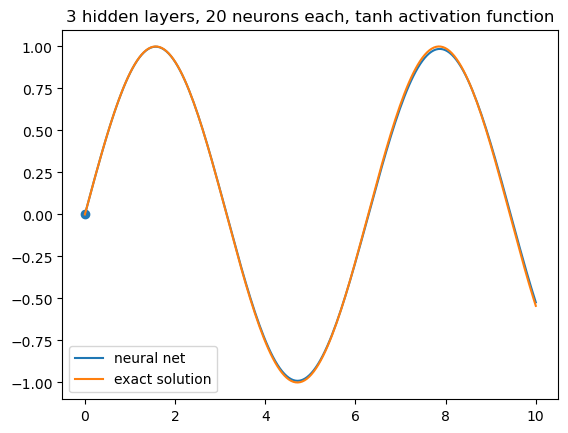

In [10]:
t_test=np.linspace(0,10,200).reshape(200,1)
pt_t_test = Variable(torch.from_numpy(t_test).float(), requires_grad=False).to(device)
u_test=model(pt_t_test)
plt.plot(t_test,u_test.detach().numpy())
plt.plot(t_test, np.sin(t_test))
plt.scatter(0,0)
plt.title('3 hidden layers, 20 neurons each, tanh activation function')
plt.legend(['neural net','exact solution'])

In [ ]:
print(model(pt_t_bc))